# Loop with several UQ Predictors 

Aim to show and test several UQ baseline approachs implement as UQEstimators
UQEstimators can be wrapped witthin a UQModels that also can include a Non-UQ predictor.

In [3]:
import ipykernel
import uqmodels
import xgboost
import os
import numpy as np
path = '.'
storing = path + '/data/'

# Preprocessing 

In [4]:
import uqmodels.processing as proc 
import uqmodels.preprocessing.Custom_Preprocessor as preproc
from uqmodels.processing import Data_loader
from uqmodels.processing import Pipeline
from uqmodels.preprocessing.Custom_Preprocessor import dict_to_TS_Dataset
from copy import deepcopy

#Data loading & Preprocessing

filename = 'synthetic_dataset.p'

# Instanciate Data_loader 
data_loader = Data_loader()

# Apply data_loader to get rowdata
dict_data = data_loader.load({'storing':storing,'keys':[filename]})
preprocessor = dict_to_TS_Dataset()
pipeline = Pipeline(data_loader=data_loader,list_processors=[preprocessor])
#Define query link to load api and add a 'name' key which is recover by the preprocessor to provide a name to the dataset
list_query = [{'storing':storing,'keys':[filename],'name':'Synthetic_data'}]

#It provide a data_generator (yield) that provide each processed data one by one.
dataset_generator = pipeline.transform(list_query) 

# Execute preprocessing pipeline :  
X, y, sample_weight, x_split, context, objective, name = next(dataset_generator)
train = x_split==1
test = np.invert(train)
print('X shape:',X.shape,'y: yshape',y.shape,'Name:',name)

#Mask for visualisation graphics
f_obs= np.arange(len(y))[test][0:500]

Pipeline : No cache data found : load data and execute the whole pipeline
X shape: (9600, 21) y: yshape (9600, 1) Name: Synthetic_data


# Evaluation function

In [5]:
import uqmodels.evaluation.base_metrics as base_metrics
from sklearn.metrics import mean_squared_error

def print_metrics(y,y_pred,y_pred_lower,y_pred_upper,train,test):

    if not(y_pred is None):
        print('MSE TRAIN:',np.round(base_metrics.mean_squared_error(y[train],y_pred[train]),2),
            'MSE TEST:',np.round(base_metrics.mean_squared_error(y[test],y_pred[test]),2))
    else:
        print('Prediction without Mean')

    if not(y_pred_lower is None):
        print('Coverage TRAIN:',np.round(base_metrics.average_coverage(y[train],y_pred_lower[train],y_pred_upper[train]),2),
            'Coverage TEST:',np.round(base_metrics.average_coverage(y[test],y_pred_lower[test],y_pred_upper[test]),2))

        print('ACE TRAIN:',np.round(base_metrics.ace(y[train],y_pred_lower[train],y_pred_upper[train],alpha),2),
            'ACE TEST:',np.round(base_metrics.ace(y[test],y_pred_lower[test],y_pred_upper[test],alpha),2))

        
        print('Sharpness TRAIN:',np.round(base_metrics.sharpness(y_pred_lower[train],y_pred_upper[train]),2),
            'Sharpness TEST:',np.round(base_metrics.sharpness(y_pred_lower[test],y_pred_upper[test]),2))
    else :
        print('Prediction without PIs')

# Base estimator

In [7]:
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor

# base regressor
model_gbr = GradientBoostingRegressor()
model_rf = RandomForestRegressor()

# Target miscoverage :
alpha = 0.05

import json

with open("model_parameters/grid_param_gbr.json") as json_file:
    gbr_config = json.load(json_file)
    # Processing to update entries with integers where needed
    for key, entry in gbr_config.items():
        if (type(entry) is float) and (gbr_config[key] == int(entry)):
            gbr_config[key] = int(entry)
    # Model with best hp configuration

    import json

with open("model_parameters/grid_param_rf.json") as json_file:
    rf_config = json.load(json_file)
    # Processing to update entries with integers where needed
    for key, entry in rf_config.items():
        if (type(entry) is float) and (rf_config[key] == int(entry)):
            rf_config[key] = int(entry)
    # Model with best hp configuration

n_greedsearch = 10

# Specification of UQ_Estimators to test

In [8]:
import uqmodels.modelization.UQEstimator as UQ_esti
import uqmodels.postprocessing.UQ_processing as UQ_proc
import uqmodels.visualization.visualization as visu
import uqmodels.evaluation.metrics as metrics

import uqmodels.modelization.ML_estimator.baseline as baseline
from uqmodels.modelization.ML_estimator.random_forest_UQ import RF_UQEstimator,get_params_dict

alpha= 0.1
# PI model based on Gaussian process regression
list_UQEstimator_initialisers = []
list_UQEstimator_parameters = []
list_params_tunning=[]


# PIs models based on ML regression UQ (with sigma and 2sigma gaussian hypothesis)
for type_UQ in ['var']:
    list_UQEstimator_initialisers.append(UQ_esti.MeanVarUQEstimator)
    list_UQEstimator_parameters.append({'estimator':model_gbr,'estimator_var':model_rf,'type_UQ':type_UQ})
    
# Quantile base predictor
list_quantile_estimators = []
list_quantile_estimators.append(GradientBoostingRegressor(random_state=0, loss='quantile', alpha=0.05))
list_quantile_estimators.append(GradientBoostingRegressor(random_state=0, loss='quantile', alpha=0.5))
list_quantile_estimators.append(GradientBoostingRegressor(random_state=0, loss='quantile', alpha=0.95))

for type_UQ in ['quantile','res_quantile']:
    list_UQEstimator_initialisers.append(UQ_esti.QuantileUQEstimator)
    list_UQEstimator_parameters.append({'list_estimators':list_quantile_estimators,
                                'list_alpha':[0.05,0.5,0.95],
                                'type_UQ':type_UQ})


# PI model based on Gaussian process regression
list_UQEstimator_initialisers.append(baseline.GPR_UQEstimator)
list_UQEstimator_parameters.append({'drop_ratio':0.95})  
    
# PIs models based on ML regression UQ (with sigma and 2sigma gaussian hypothesis)
for type_UQ in ['var','2var','res_var','res_2var']:
    estimator = deepcopy(model_gbr)
    print(estimator)
    list_UQEstimator_initialisers.append(baseline.REGML_UQEstimator)
    list_UQEstimator_parameters.append({'estimator':estimator,
                                        'estimator_var':deepcopy(estimator),
                                        'type_UQ':type_UQ})


# PI model based on Grandient boosting quantile regression
for type_UQ in ['quantile','res_quantile']:
    estimator=deepcopy(model_gbr)
    list_UQEstimator_initialisers.append(baseline.GBRQ_UQEstimator)
    list_UQEstimator_parameters.append({'list_alpha':[0.05,0.5,0.95],
                                        'type_UQ':type_UQ})


# PIs models based on RF_UQ UQ (with sigma, 2sigma and empirique hypothesis)
for type_UQ in ['var','2var','quantile','var_A&E','res_var','res_2var','res_quantile']:
    dict_params = get_params_dict(beta=0.1,var_min=0.0001,n_estimators=75,max_depth=12,type_UQ=type_UQ)
    list_UQEstimator_initialisers.append(RF_UQEstimator)
    list_UQEstimator_parameters.append(dict_params)

GradientBoostingRegressor()
GradientBoostingRegressor()
GradientBoostingRegressor()
GradientBoostingRegressor()


## Traning & Inference of UQ-Estimators + KPI_processors

MeanVarUQEstimator var


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


warning y shape : (8229, 1) pred shape (8229,)
warning y shape : (9600, 1) pred shape (9600,)
MSE TRAIN: 0.14 MSE TEST: 0.17
Coverage TRAIN: 0.31 Coverage TEST: 0.33
ACE TRAIN: -0.59 ACE TEST: -0.57
Sharpness TRAIN: 1.0 Sharpness TEST: 1.1


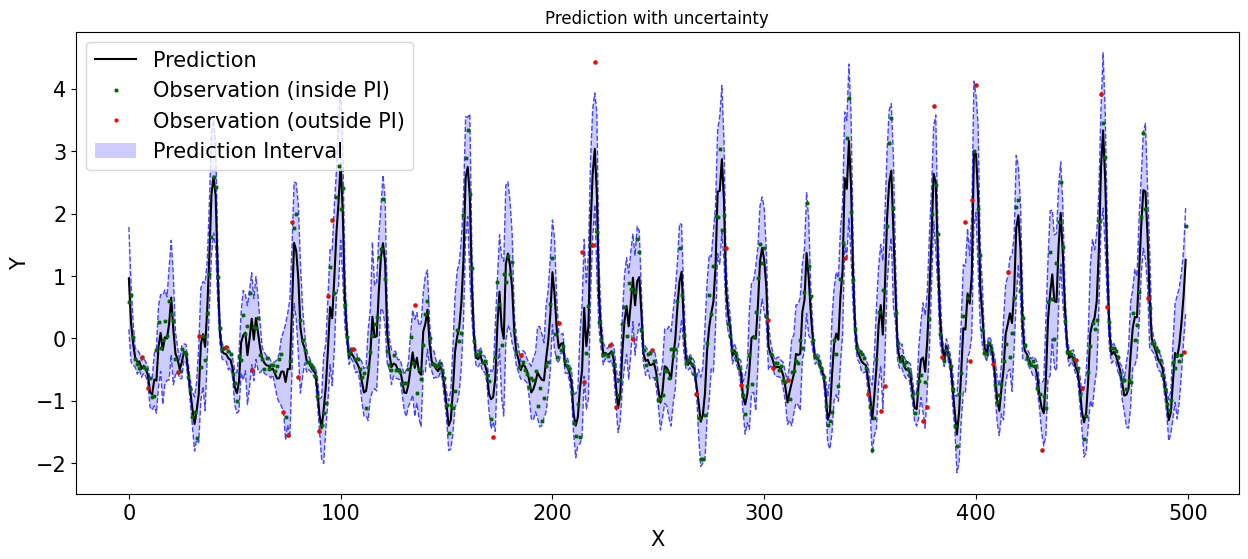

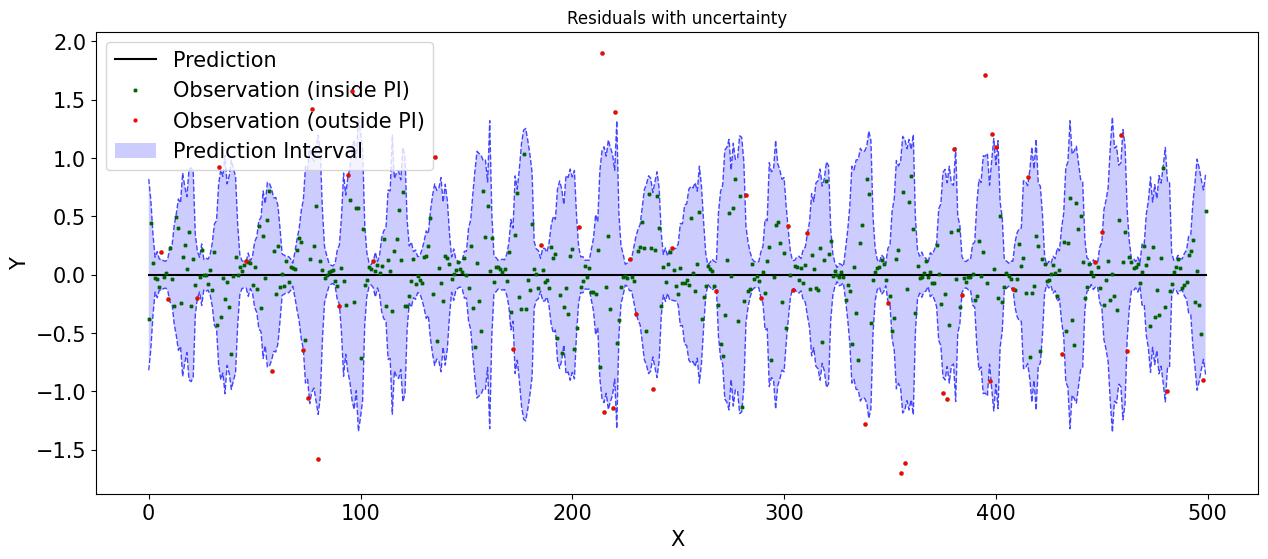

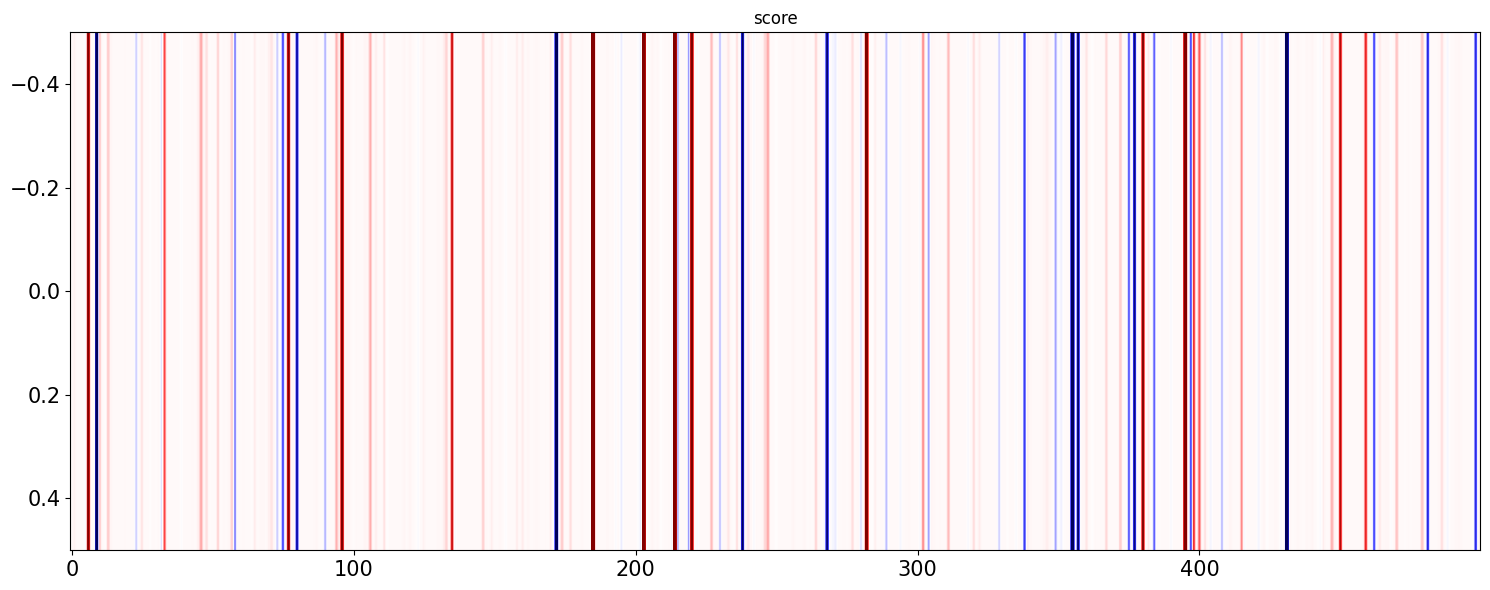

QuantileUQEstimator quantile


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


recover quantile
recover quantile
warning y shape : (8229, 1) pred shape (8229,)
warning y shape : (9600, 1) pred shape (9600,)
MSE TRAIN: 0.16 MSE TEST: 0.19
Coverage TRAIN: 0.37 Coverage TEST: 0.37


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\uqmodels\postprocessing\UQ_processing.py:663: RuntimeWarning: divide by zero encountered in divide
  res_norm[~mask, dim] = res_norm[~mask, dim] / (sigma)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


ACE TRAIN: -0.53 ACE TEST: -0.53
Sharpness TRAIN: 1.21 Sharpness TEST: 1.23


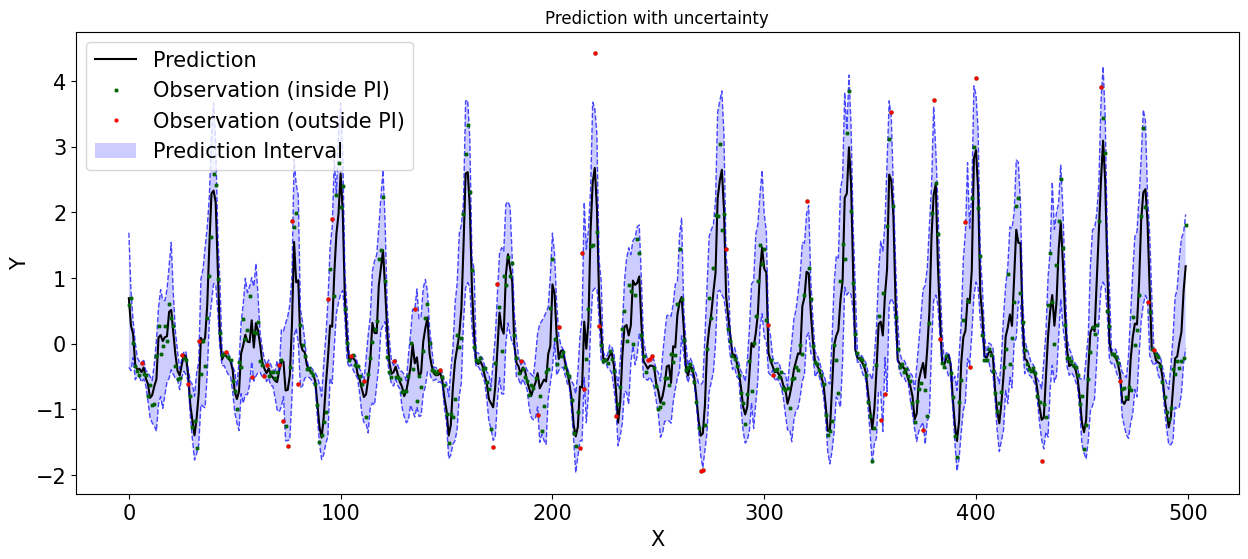

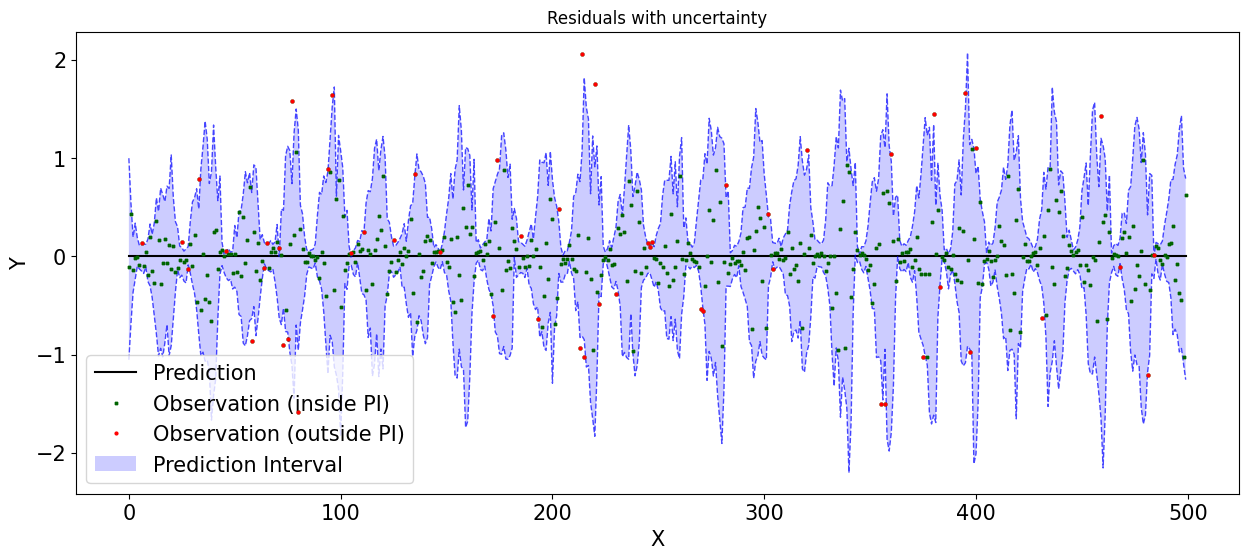

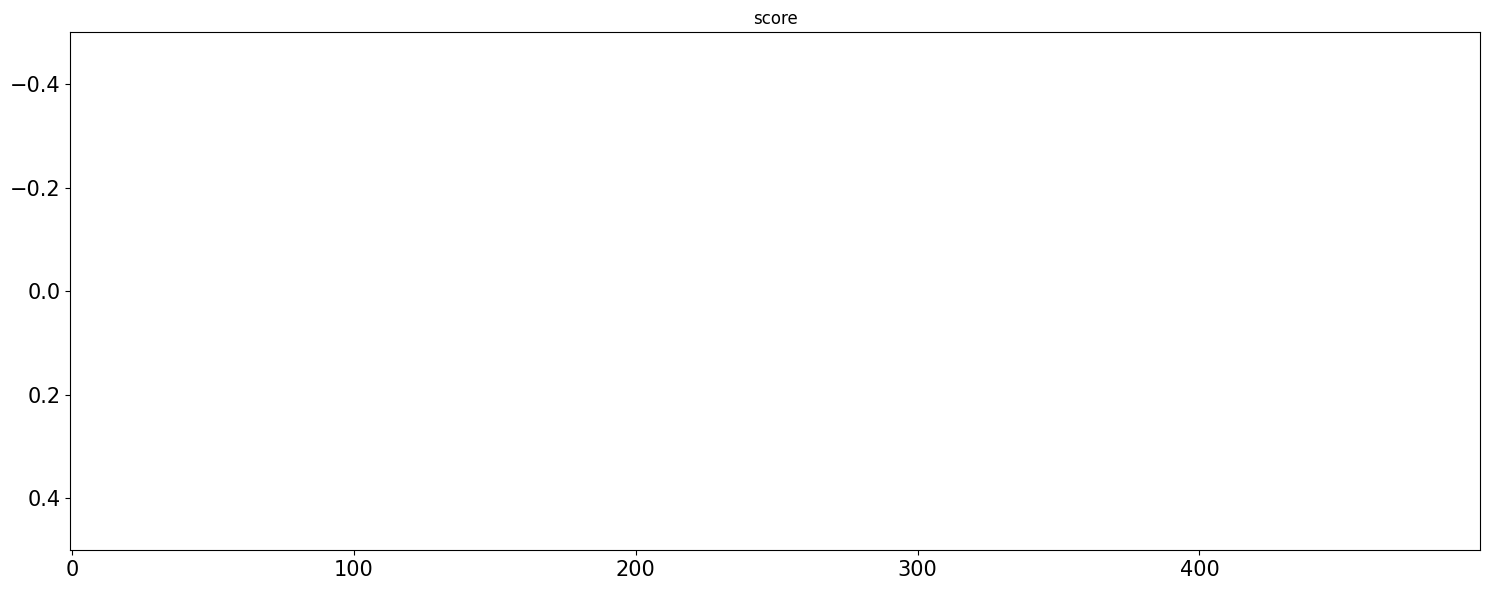

QuantileUQEstimator res_quantile


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d arr

recover quantile
recover quantile
warning y shape : (8229, 1) pred shape (8229,)
warning y shape : (9600, 1) pred shape (9600,)
MSE TRAIN: 0.13 MSE TEST: 0.17
Coverage TRAIN: 0.31 Coverage TEST: 0.3
ACE TRAIN: -0.59 ACE TEST: -0.6
Sharpness TRAIN: 1.0 Sharpness TEST: 1.0


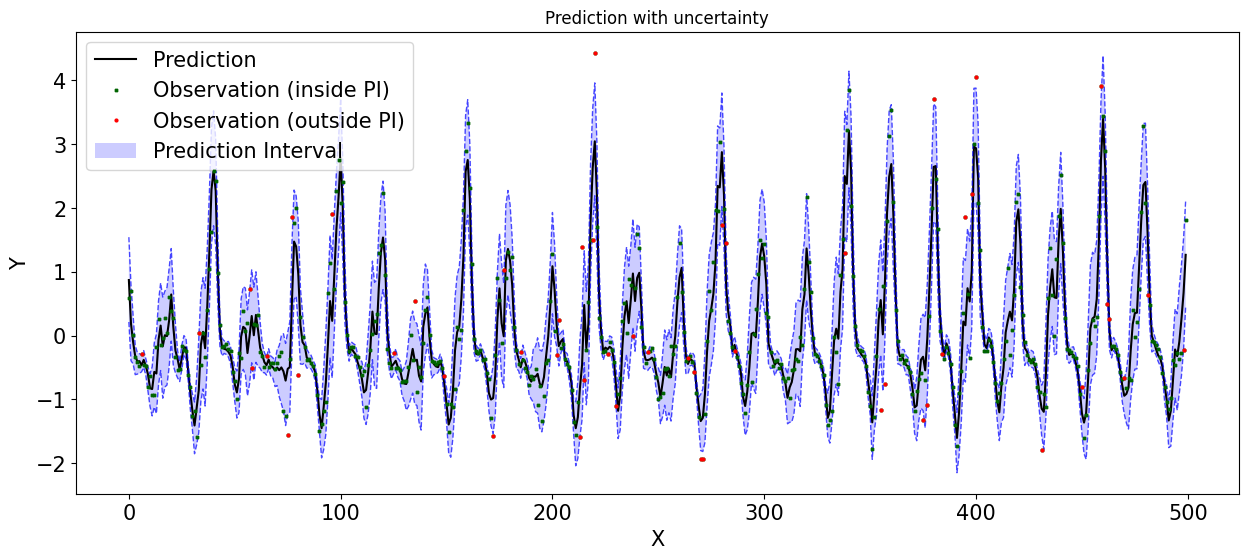

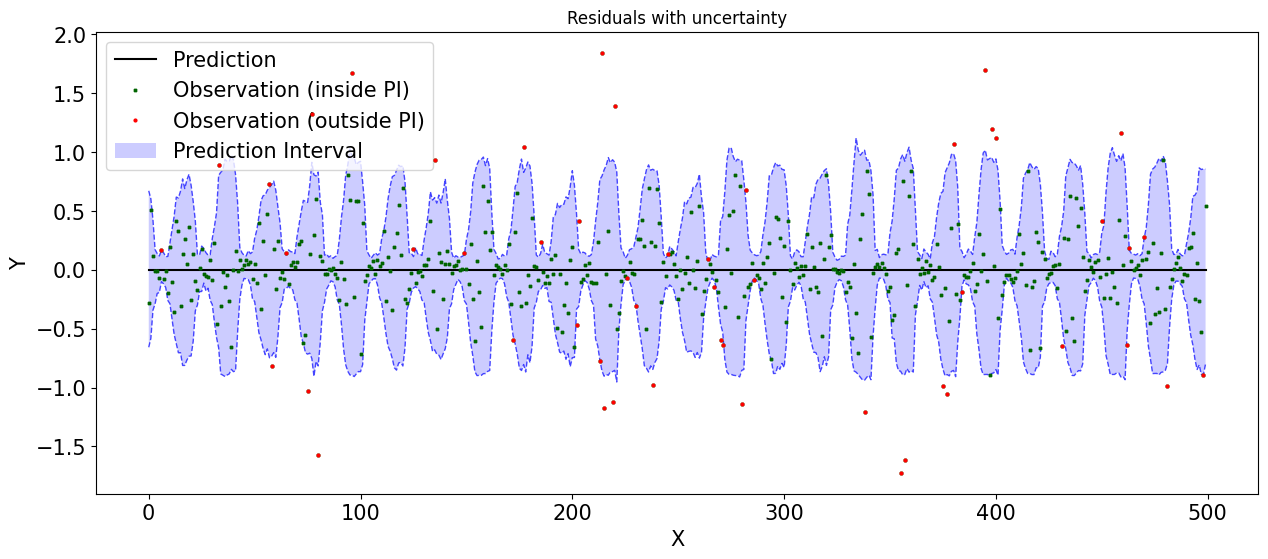

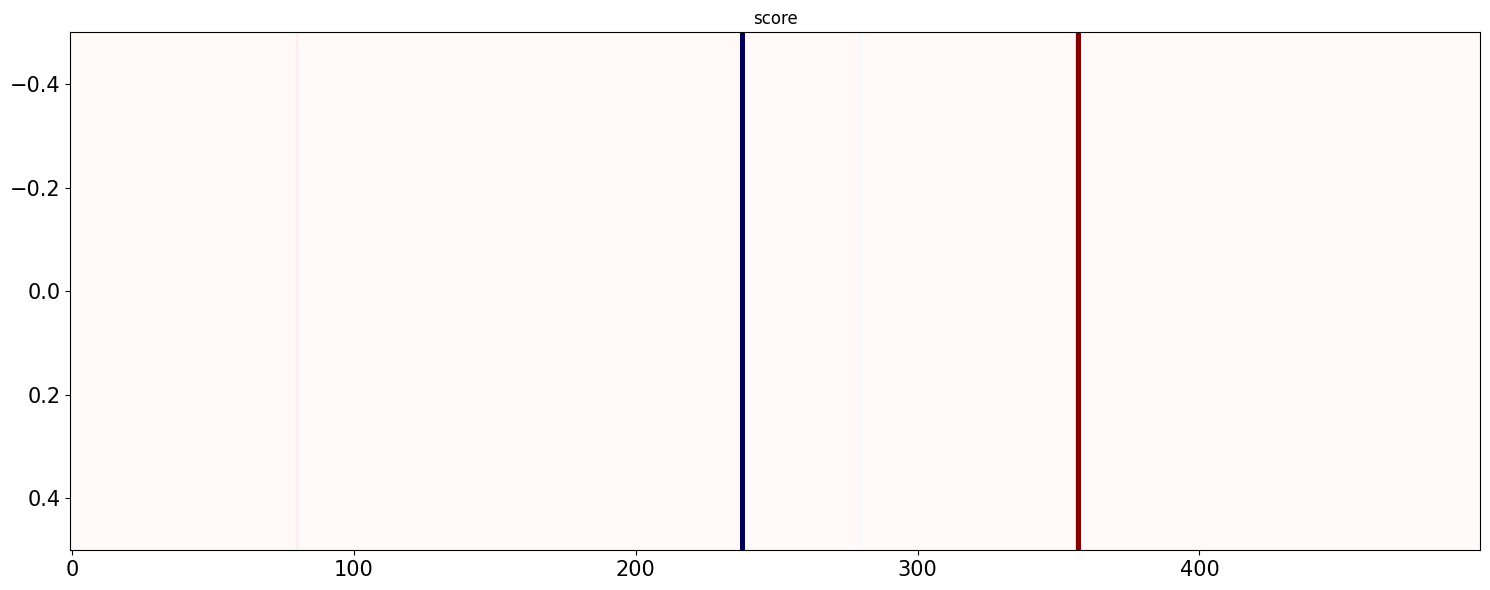

Gaussian_Process_UQ var


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


warning y shape : (8229, 1) pred shape (8229,)
warning y shape : (9600, 1) pred shape (9600,)
MSE TRAIN: 0.25 MSE TEST: 0.3
Coverage TRAIN: 0.43 Coverage TEST: 0.44
ACE TRAIN: -0.47 ACE TEST: -0.46
Sharpness TRAIN: 1.3 Sharpness TEST: 1.35


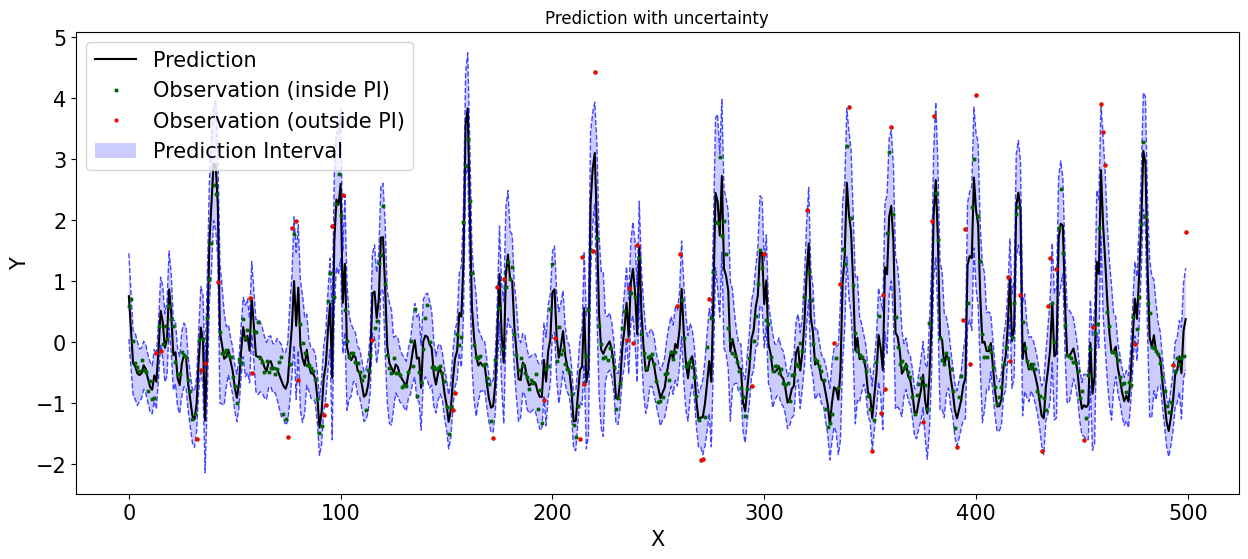

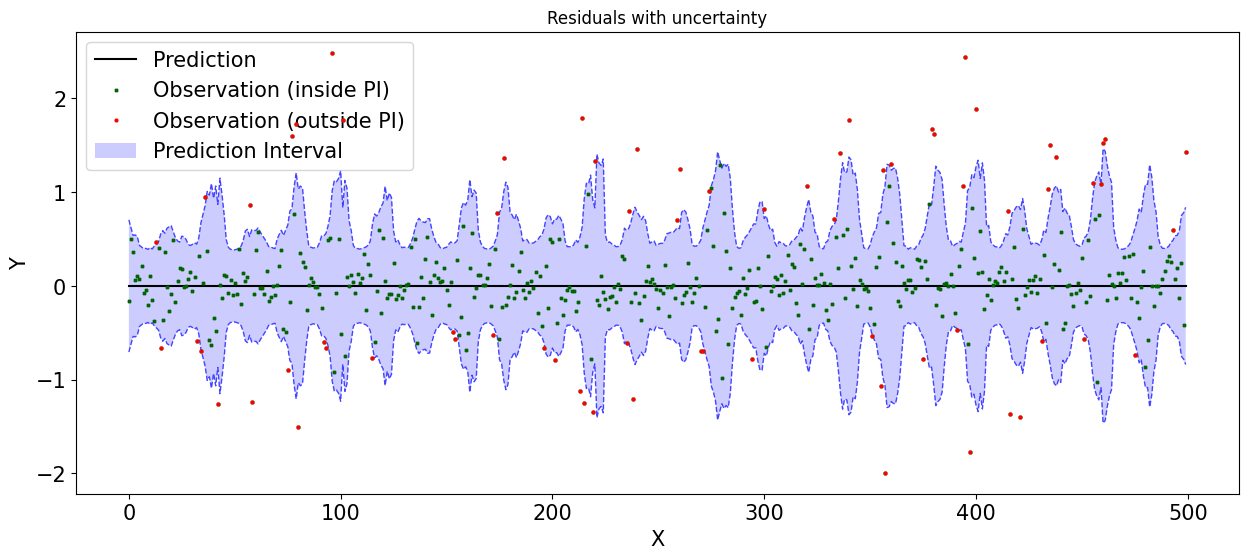

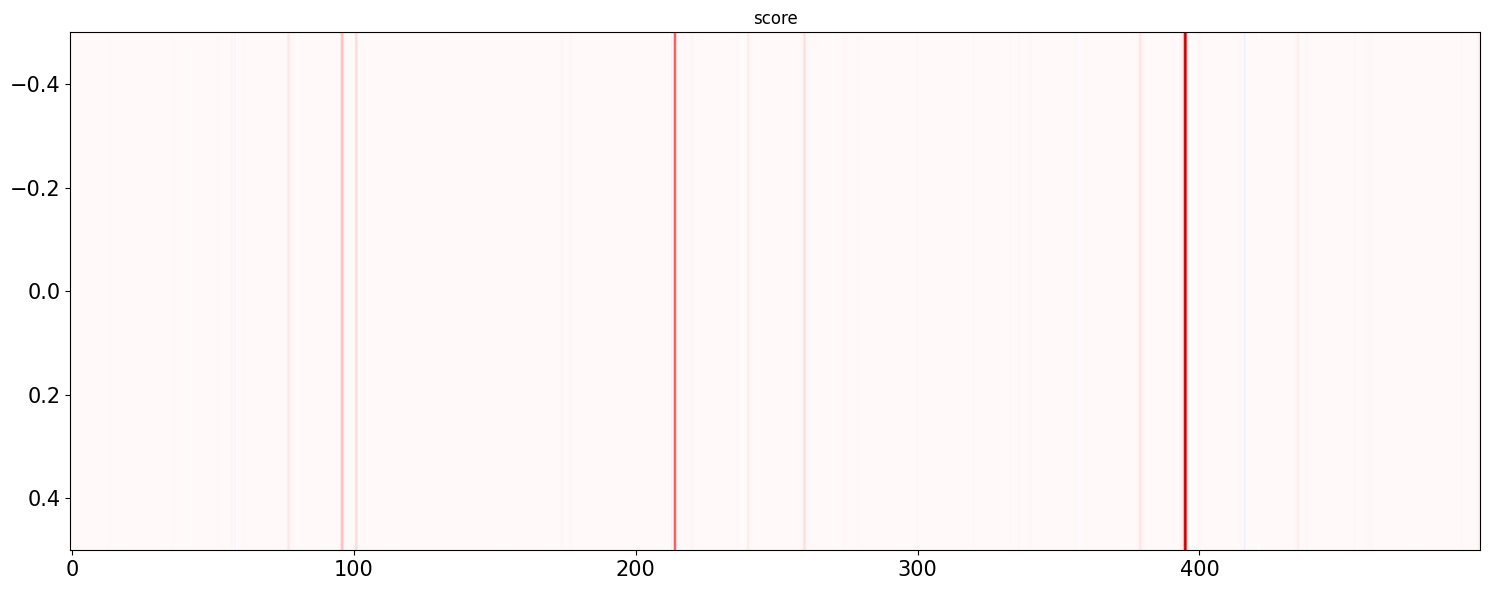

REGML_UQEstimator_var var


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


warning y shape : (8229, 1) pred shape (8229,)
warning y shape : (9600, 1) pred shape (9600,)
MSE TRAIN: 0.12 MSE TEST: 0.17
Coverage TRAIN: 0.3 Coverage TEST: 0.3
ACE TRAIN: -0.6 ACE TEST: -0.6
Sharpness TRAIN: 0.83 Sharpness TEST: 0.83


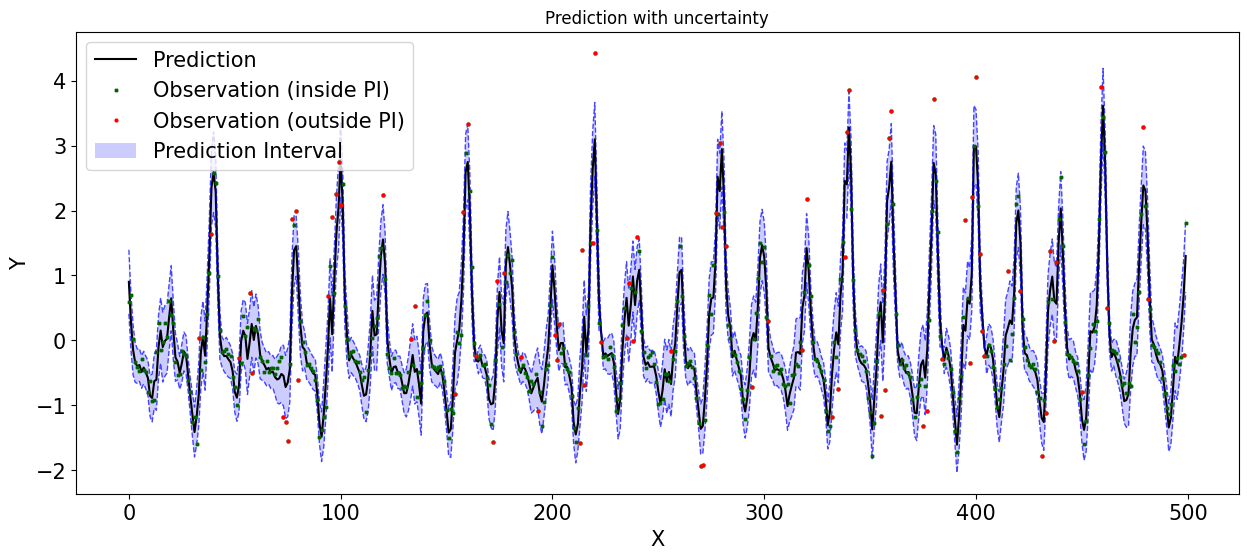

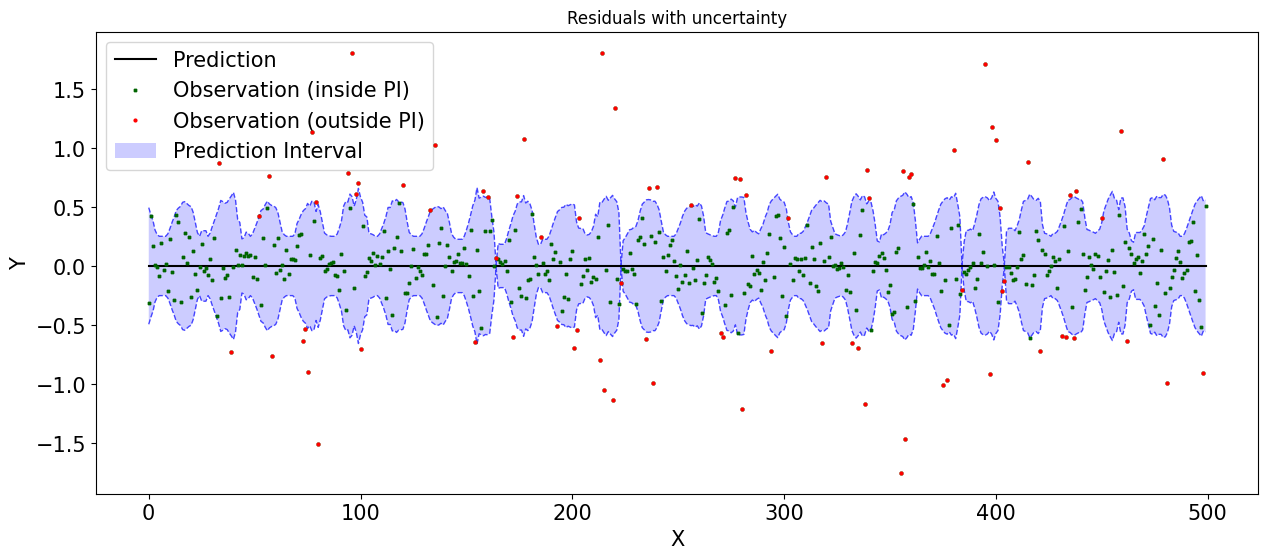

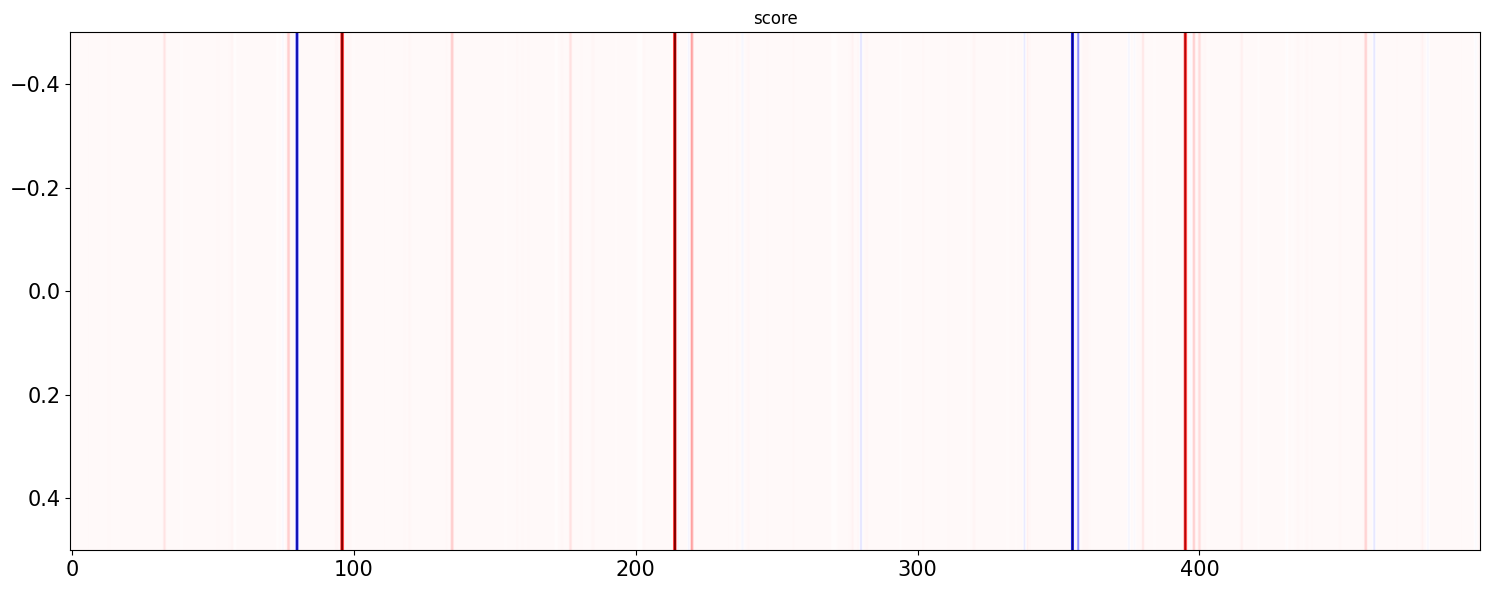

REGML_UQEstimator_2var 2var


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d arr

warning y shape : (8229, 1) pred shape (8229,)
Naïf approach mean of 2 sigma
warning y shape : (9600, 1) pred shape (9600,)
Naïf approach mean of 2 sigma
MSE TRAIN: 0.12 MSE TEST: 0.17
Coverage TRAIN: 0.32 Coverage TEST: 0.31
ACE TRAIN: -0.58 ACE TEST: -0.59
Sharpness TRAIN: 0.98 Sharpness TEST: 1.0


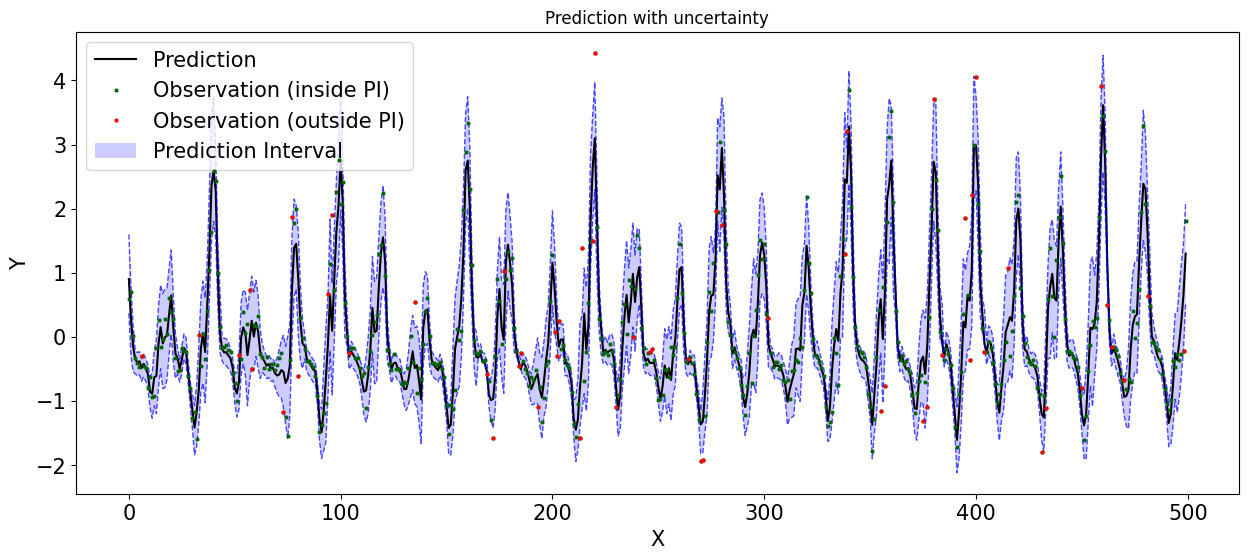

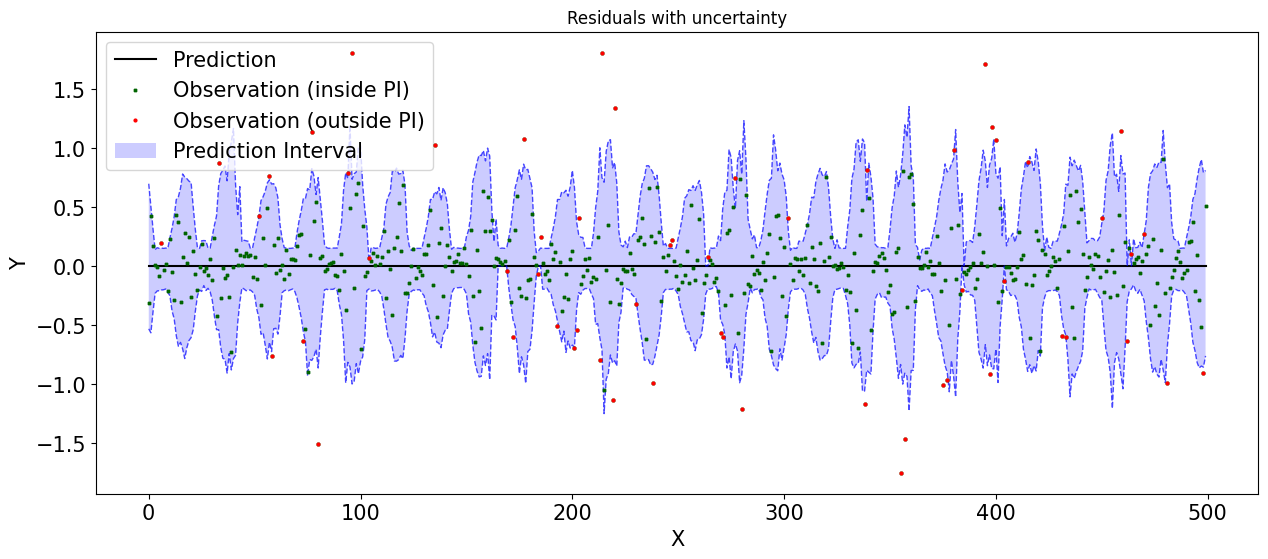

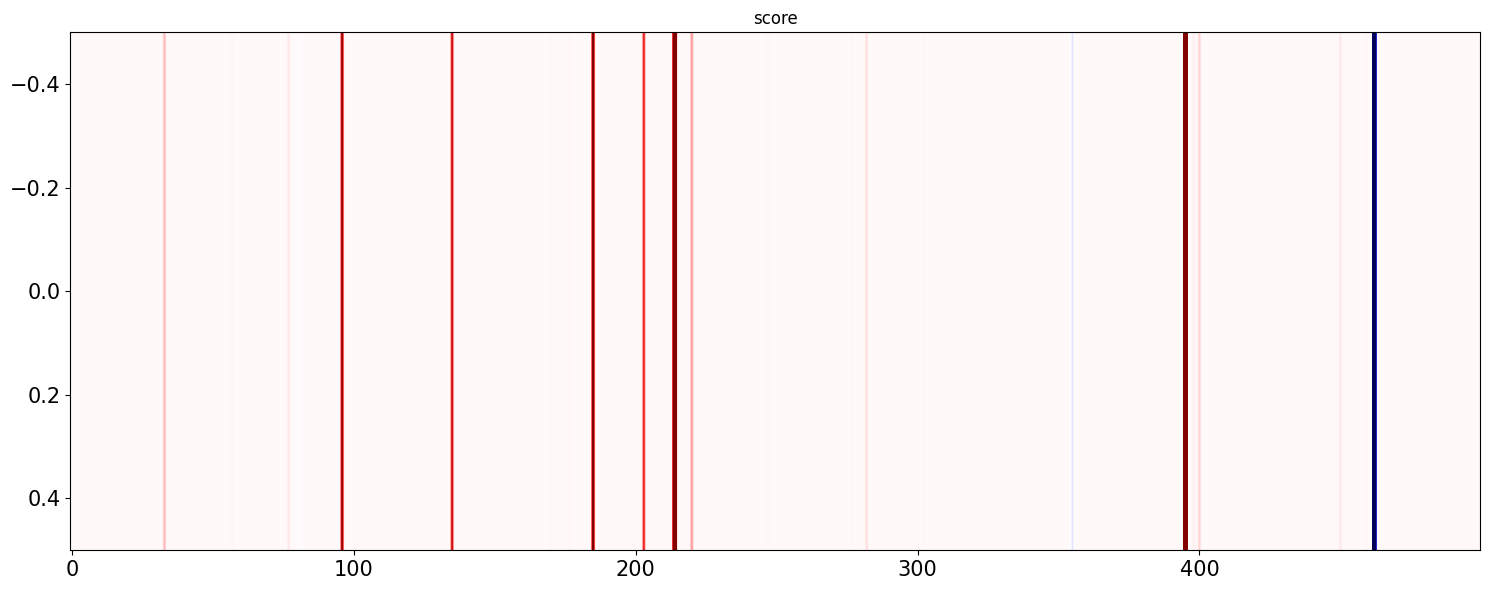

REGML_UQEstimator_res_var res_var


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d arr

warning y shape : (8229, 1) pred shape (8229,)
warning y shape : (9600, 1) pred shape (9600,)
MSE TRAIN: 0.1 MSE TEST: 0.17
Coverage TRAIN: 0.28 Coverage TEST: 0.28
ACE TRAIN: -0.62 ACE TEST: -0.62
Sharpness TRAIN: 0.78 Sharpness TEST: 0.79


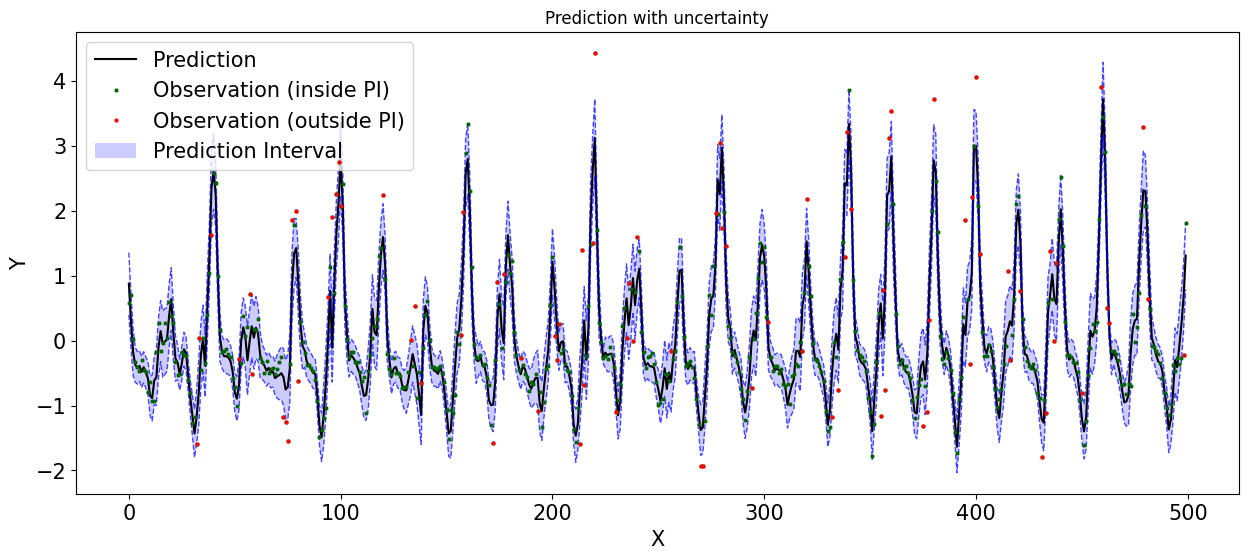

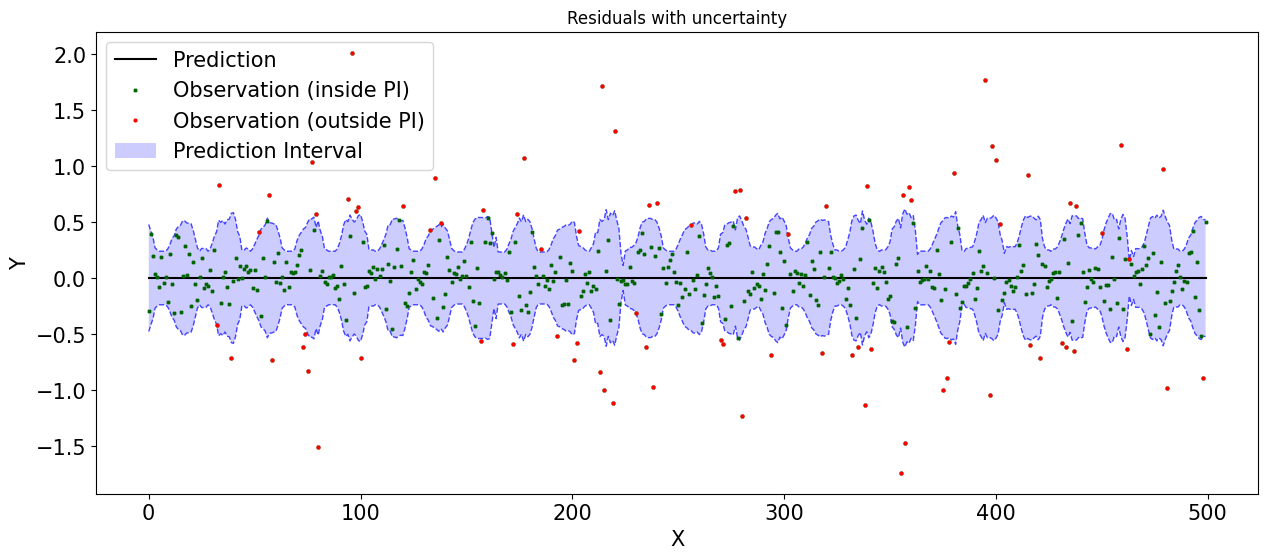

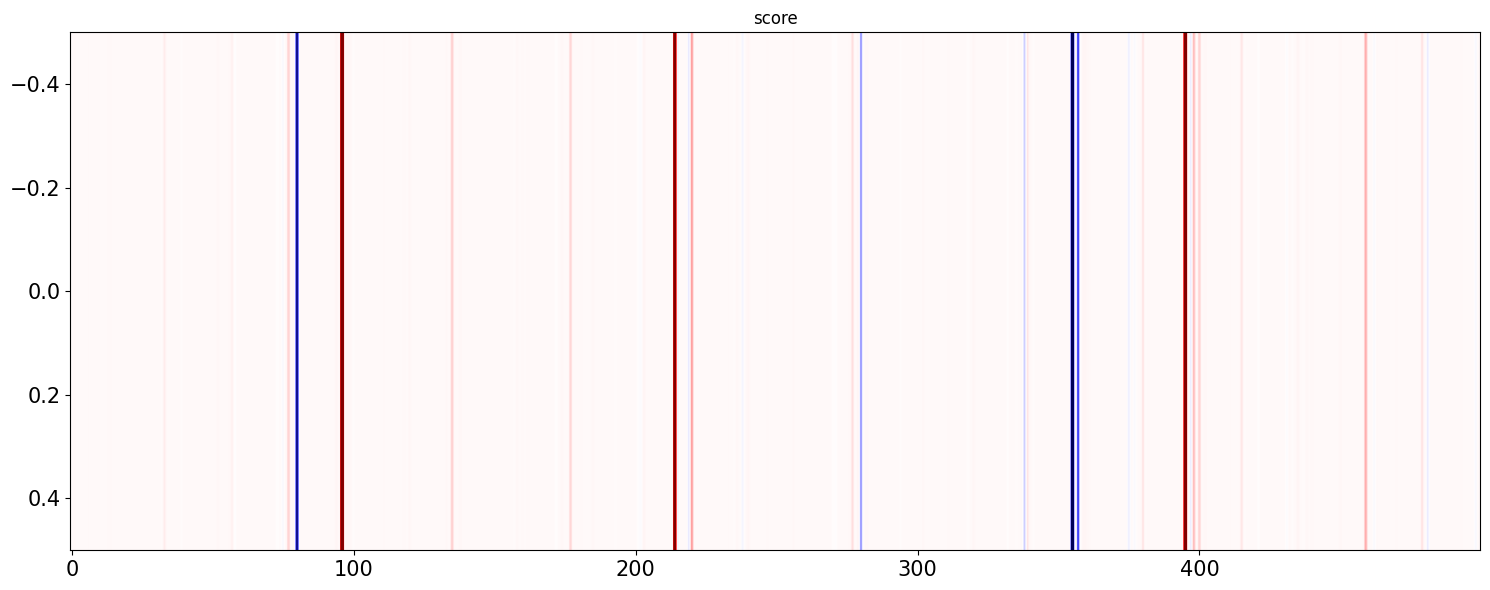

REGML_UQEstimator_res_2var res_2var


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d arr

warning y shape : (8229, 1) pred shape (8229,)
Naïf approach mean of 2 sigma
warning y shape : (9600, 1) pred shape (9600,)
Naïf approach mean of 2 sigma
MSE TRAIN: 0.1 MSE TEST: 0.17
Coverage TRAIN: 0.3 Coverage TEST: 0.29
ACE TRAIN: -0.6 ACE TEST: -0.61
Sharpness TRAIN: 0.92 Sharpness TEST: 0.93


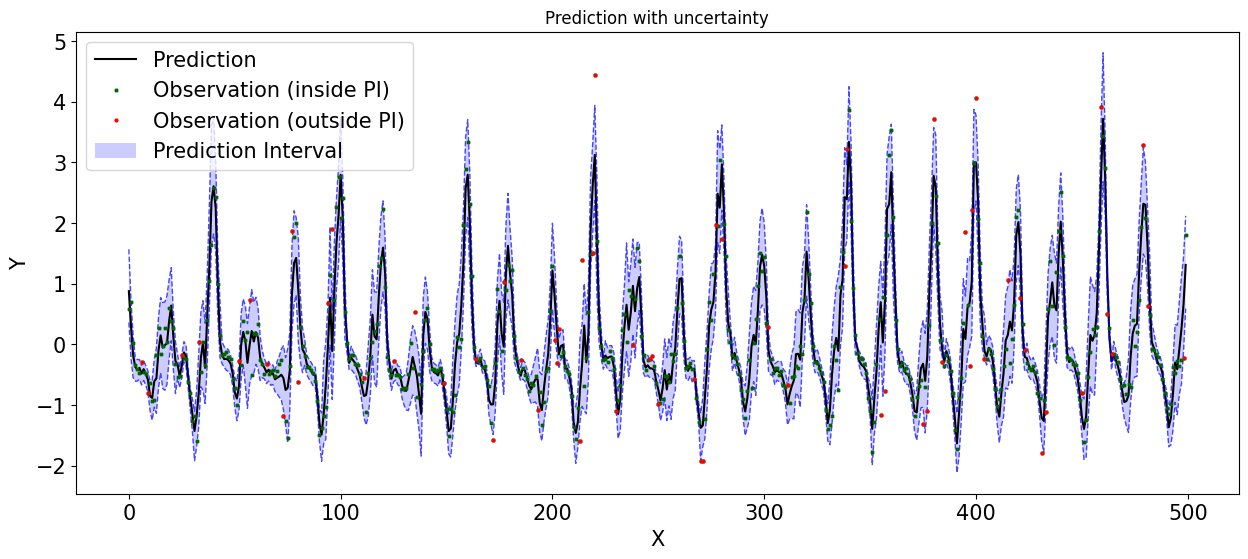

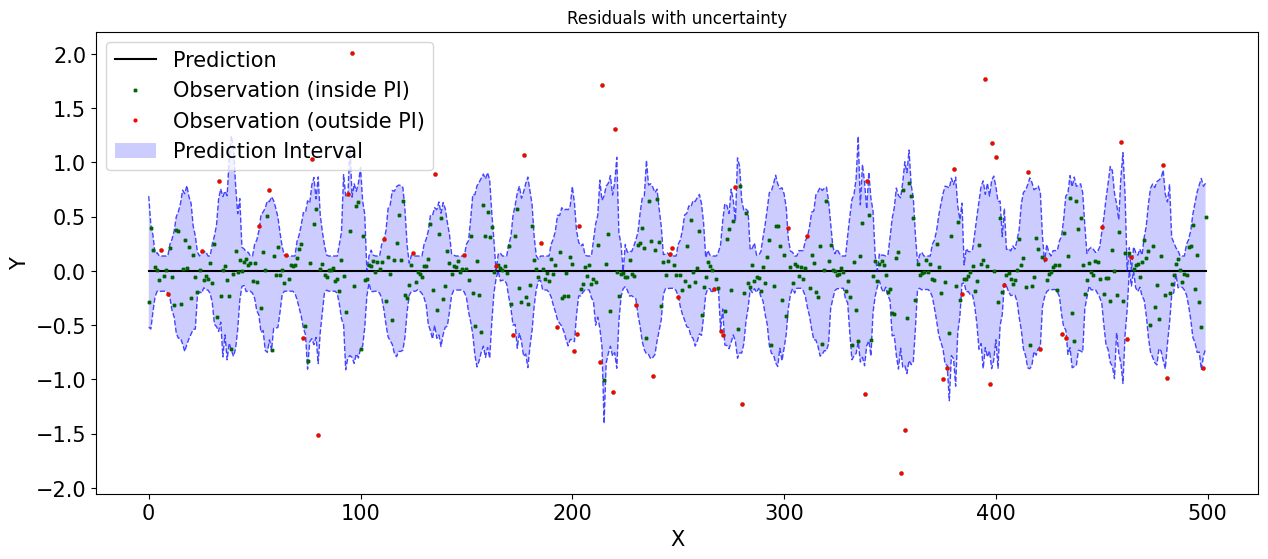

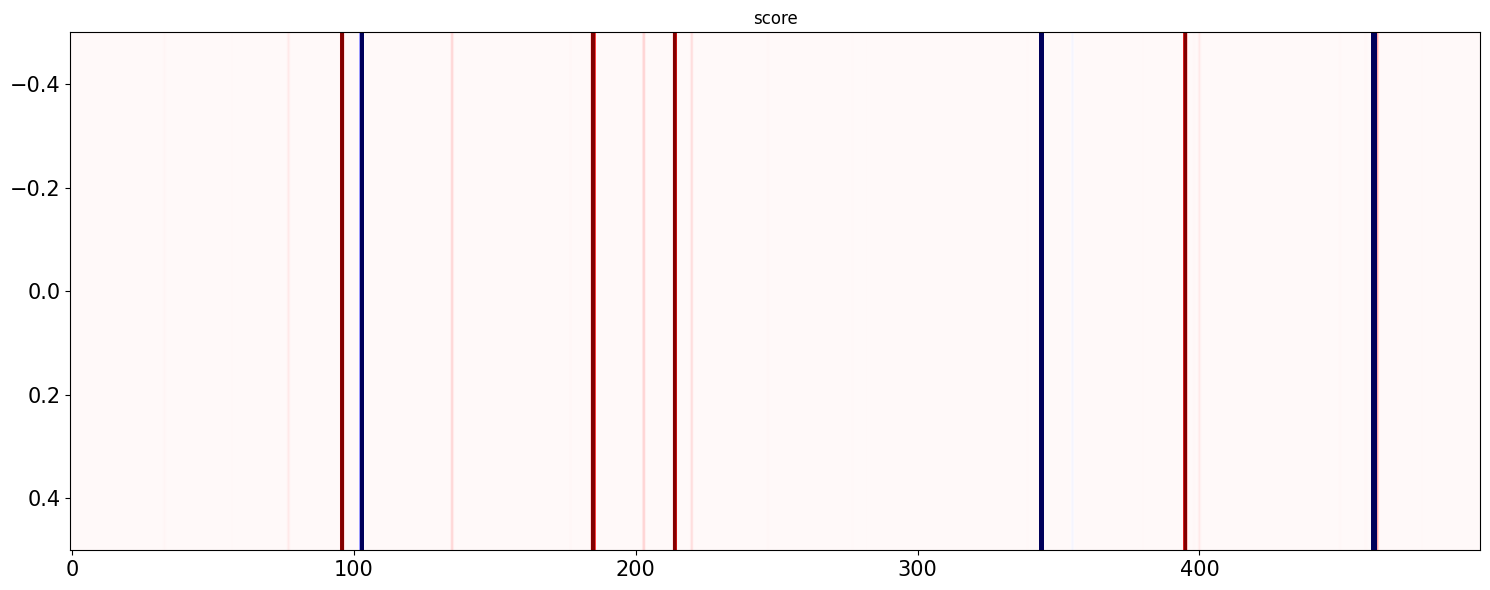

GBRQ_UQEstimator quantile


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


recover quantile
recover quantile
warning y shape : (8229, 1) pred shape (8229,)
warning y shape : (9600, 1) pred shape (9600,)
MSE TRAIN: 0.16 MSE TEST: 0.19
Coverage TRAIN: 0.37 Coverage TEST: 0.37


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\uqmodels\postprocessing\UQ_processing.py:663: RuntimeWarning: divide by zero encountered in divide
  res_norm[~mask, dim] = res_norm[~mask, dim] / (sigma)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


ACE TRAIN: -0.53 ACE TEST: -0.53
Sharpness TRAIN: 1.2 Sharpness TEST: 1.22


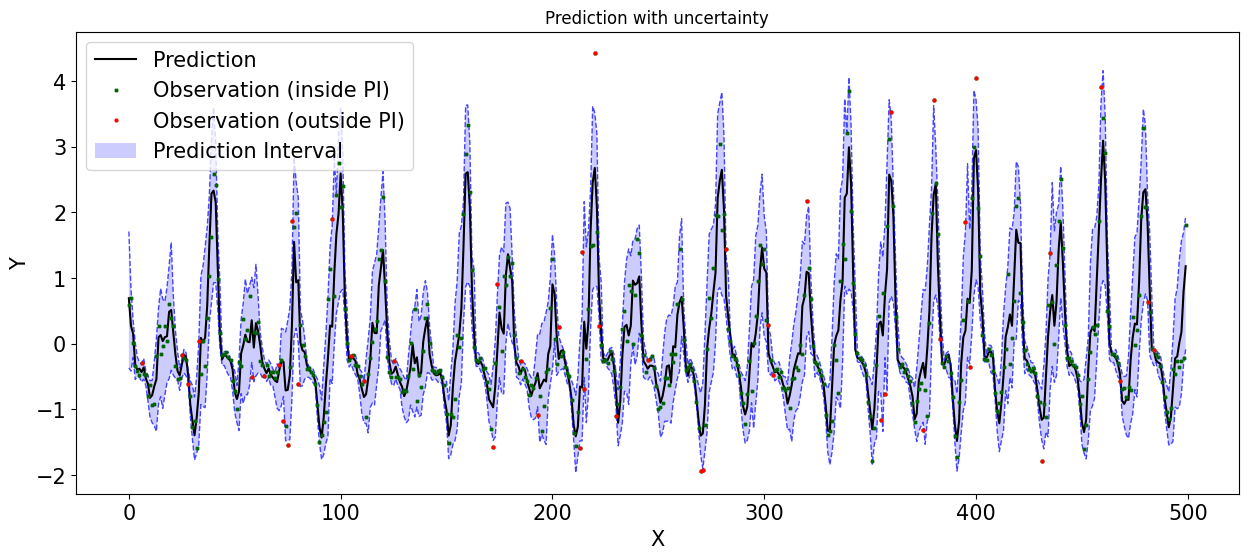

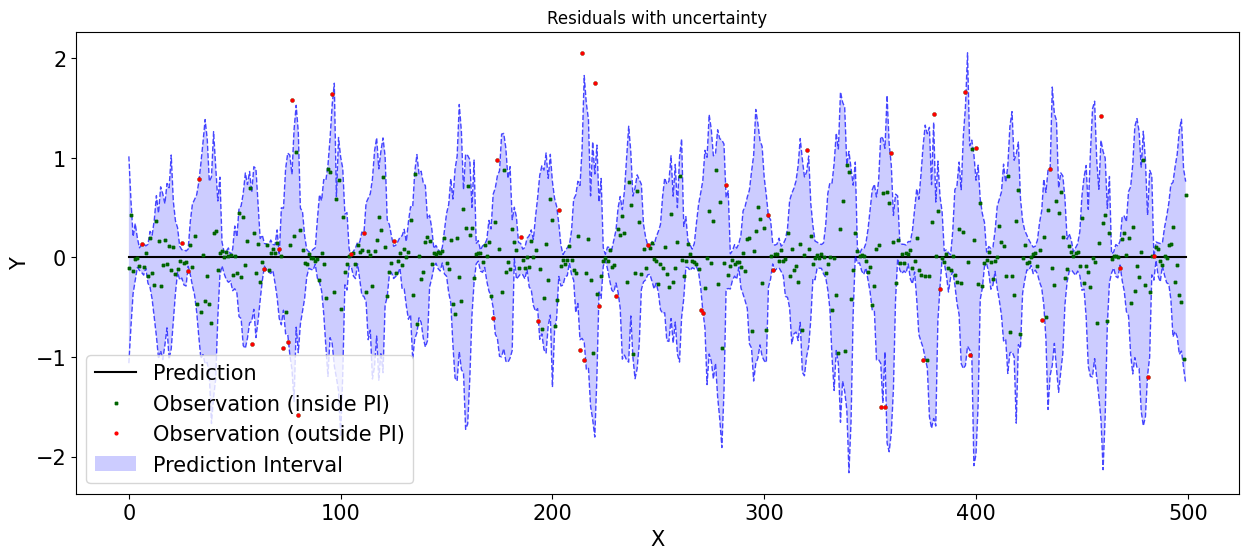

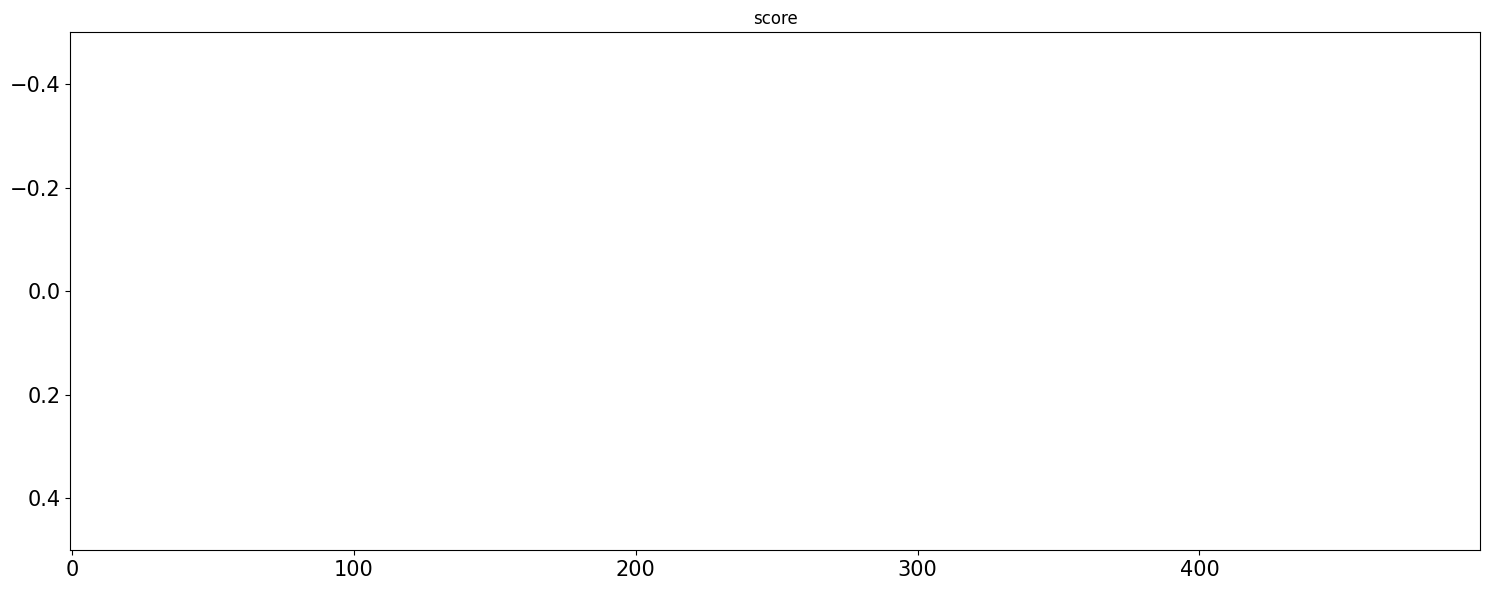

GBRQ_UQEstimator res_quantile


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d arr

recover quantile
recover quantile
warning y shape : (8229, 1) pred shape (8229,)
warning y shape : (9600, 1) pred shape (9600,)
MSE TRAIN: 0.13 MSE TEST: 0.17
Coverage TRAIN: 0.31 Coverage TEST: 0.3
ACE TRAIN: -0.59 ACE TEST: -0.6
Sharpness TRAIN: 1.0 Sharpness TEST: 1.0


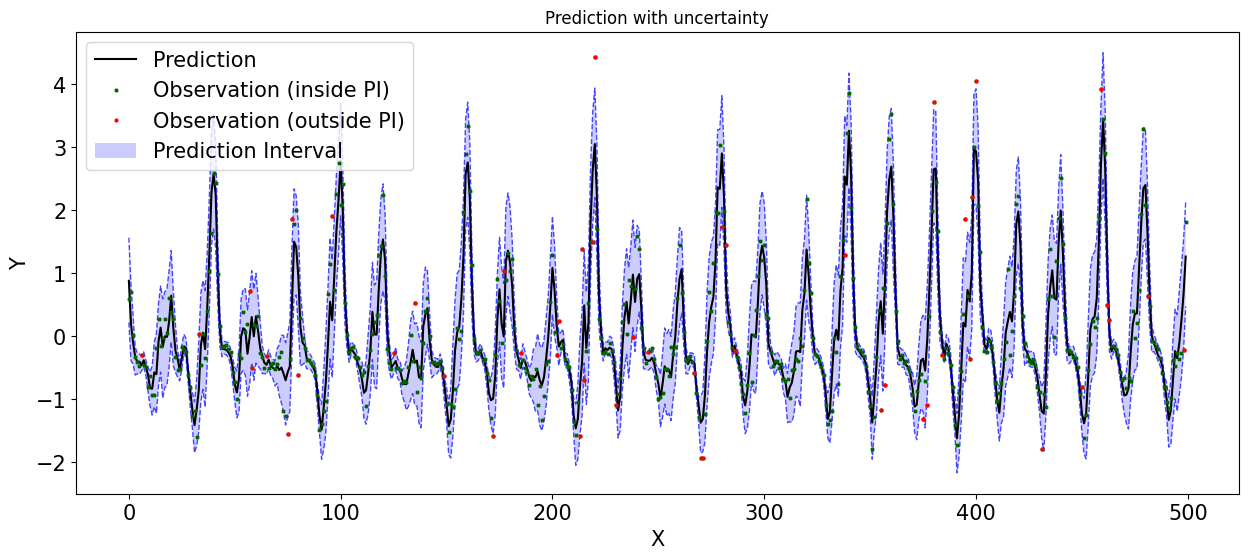

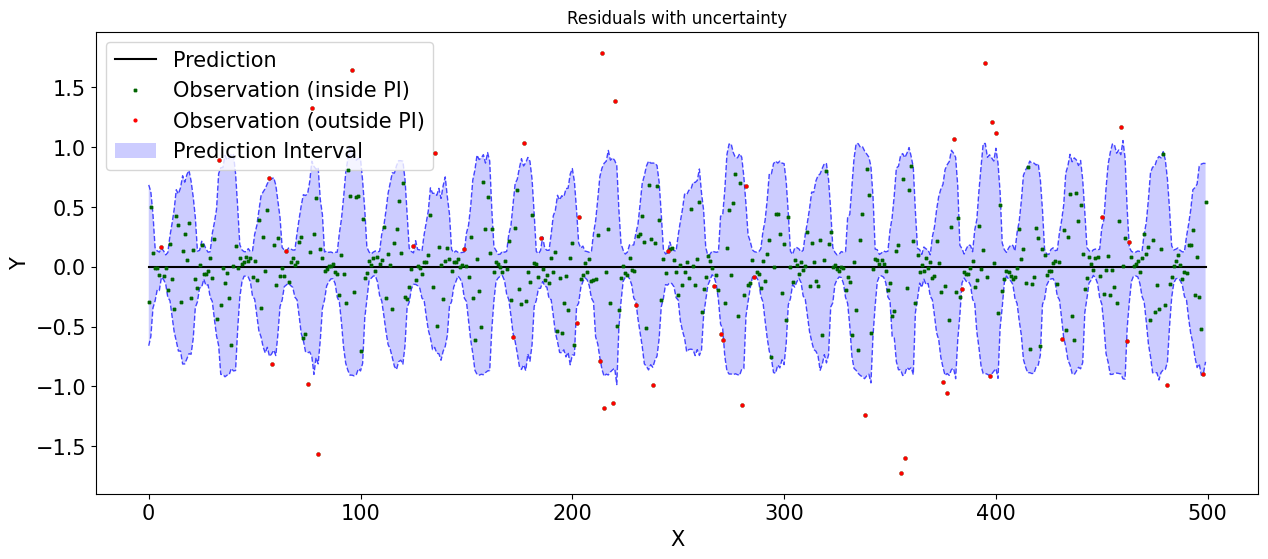

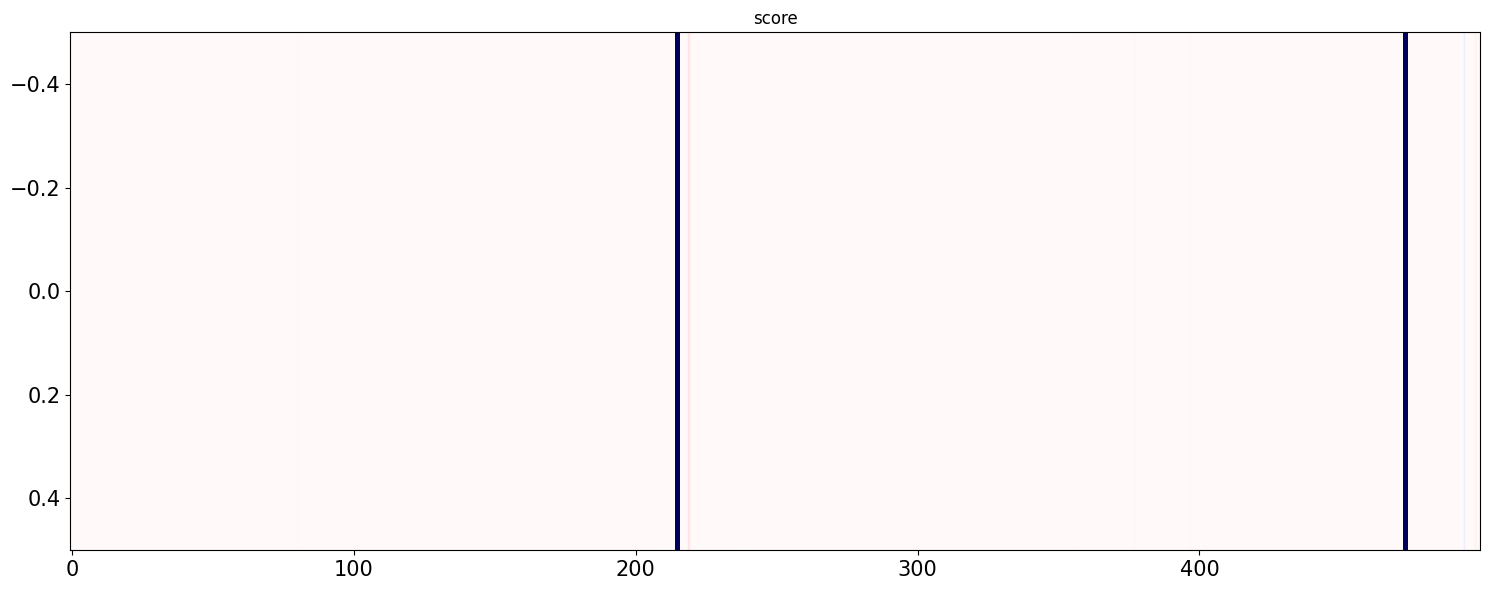

RF_UQEstimator var


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE TRAIN: 0.07 MSE TEST: 0.17
Coverage TRAIN: 1.0 Coverage TEST: 0.94
ACE TRAIN: 0.1 ACE TEST: 0.04
Sharpness TRAIN: 1.16 Sharpness TEST: 1.25


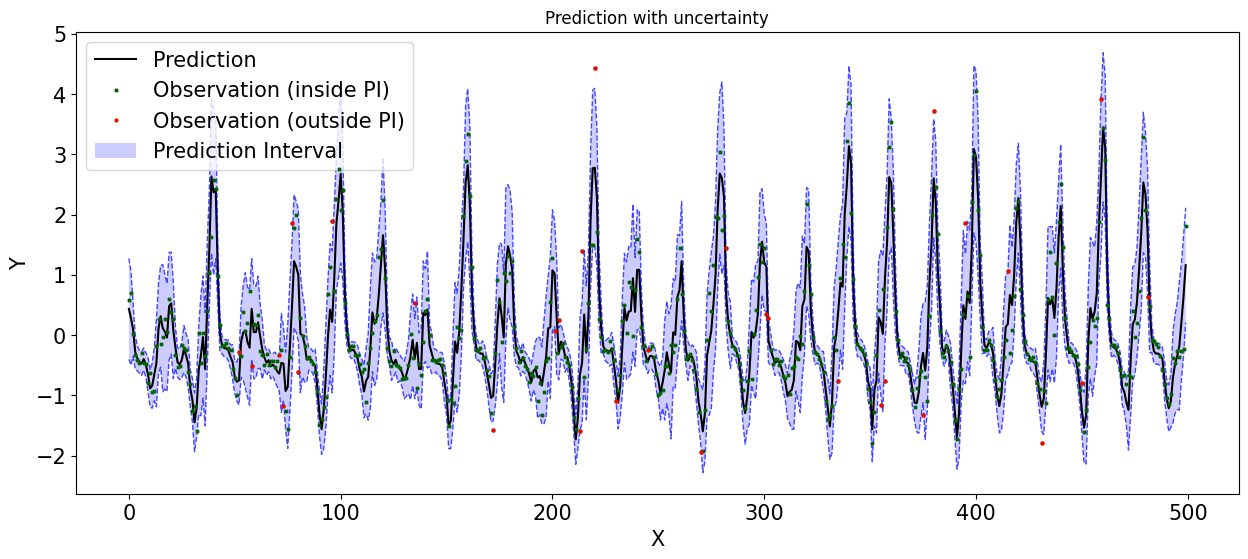

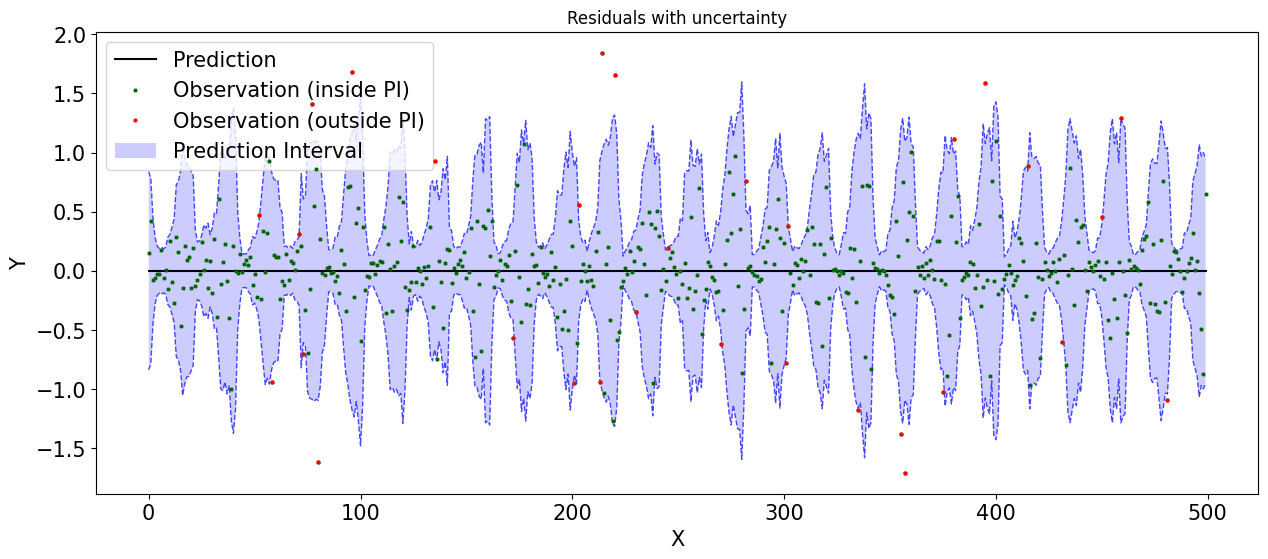

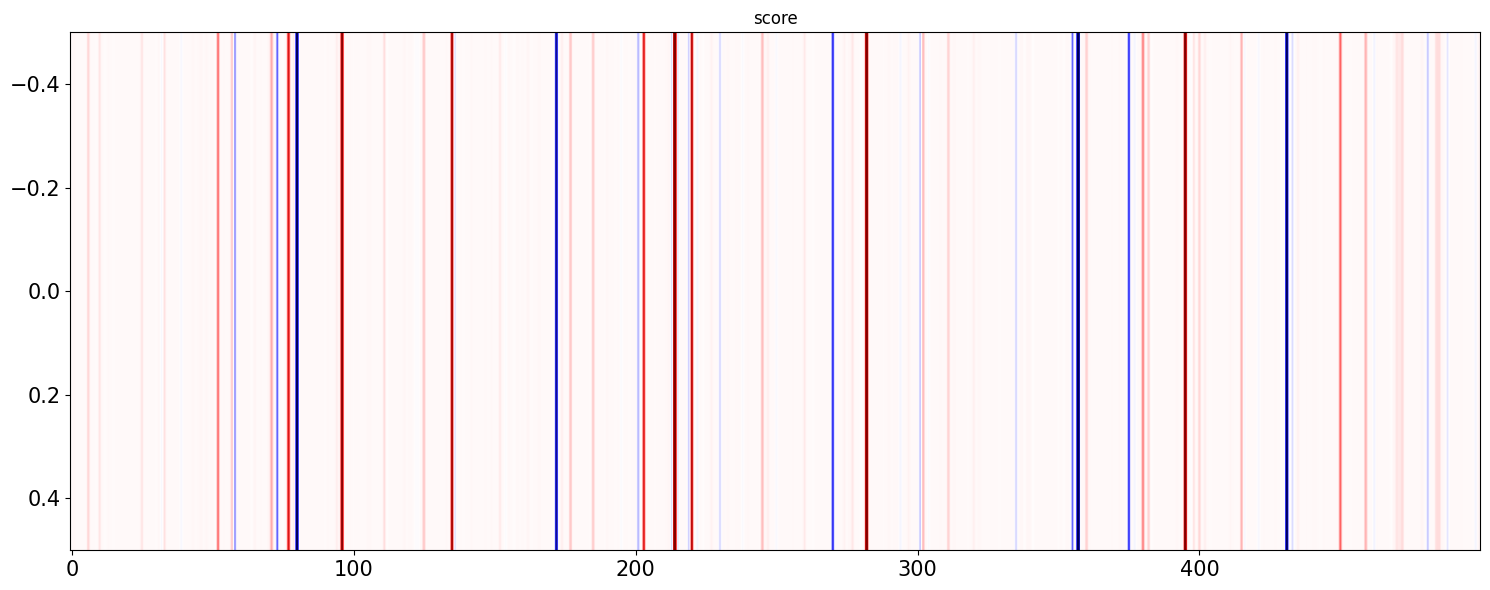

RF_UQEstimator 2var


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Naïf approach mean of 2 sigma
Naïf approach mean of 2 sigma
MSE TRAIN: 0.07 MSE TEST: 0.17
Coverage TRAIN: 0.76 Coverage TEST: 0.62
ACE TRAIN: -0.14 ACE TEST: -0.28
Sharpness TRAIN: 0.49 Sharpness TEST: 0.49


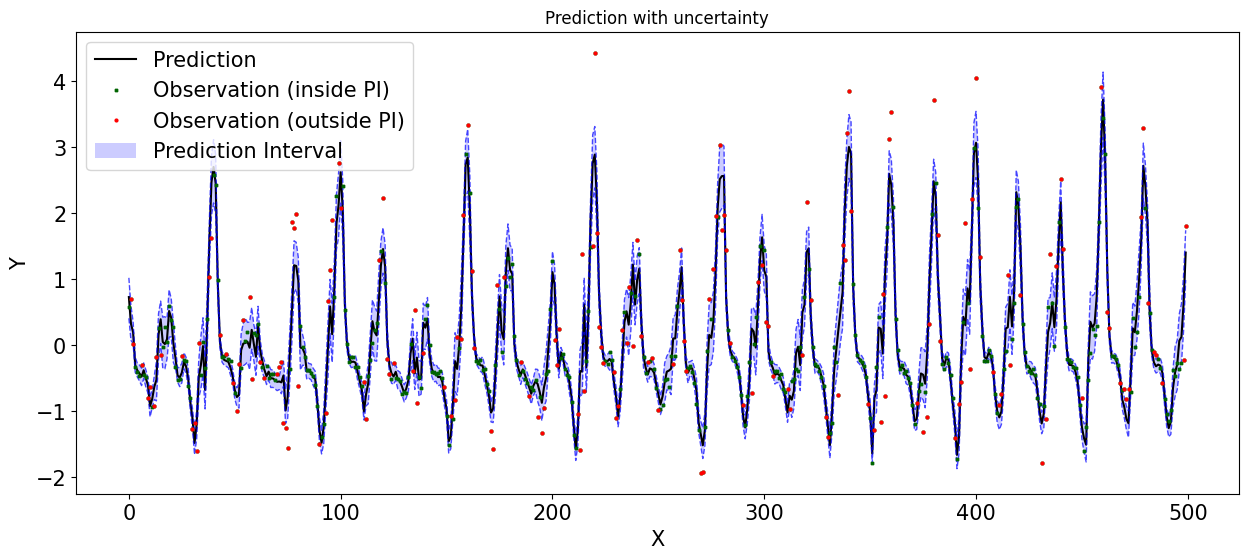

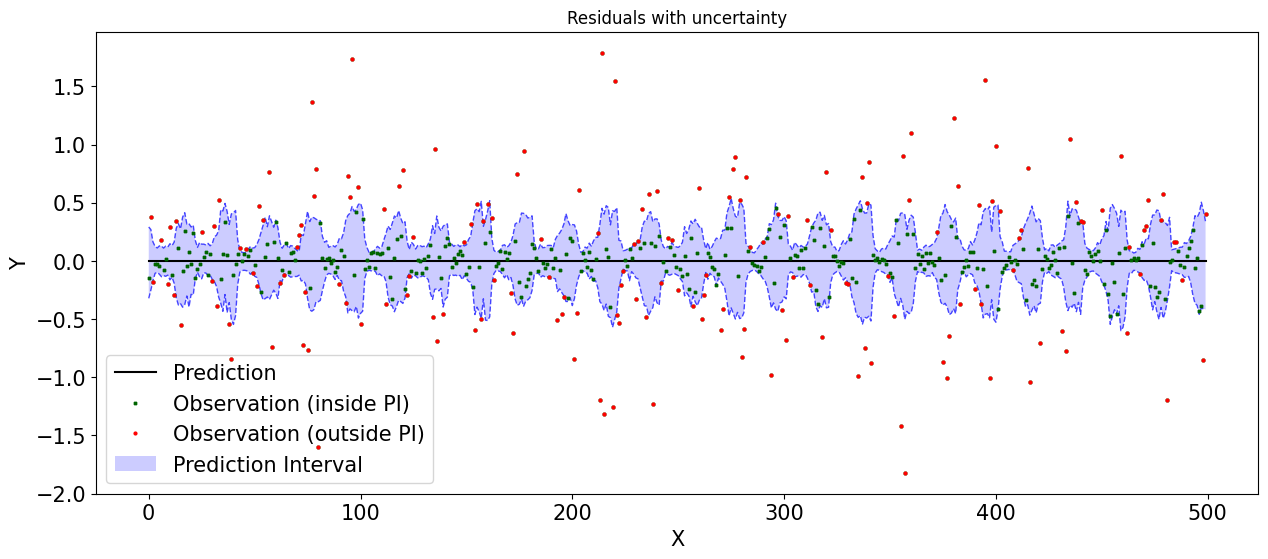

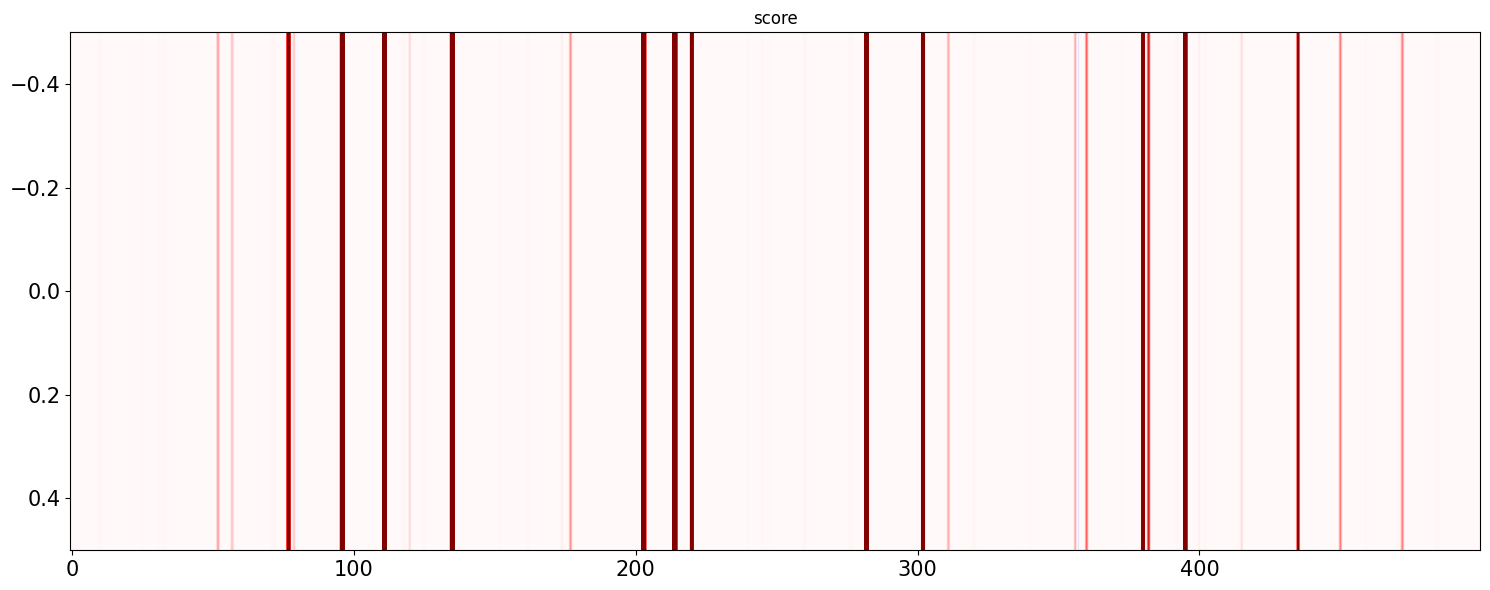

RF_UQEstimator quantile


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


recover quantile
recover quantile
MSE TRAIN: 0.07 MSE TEST: 0.17
Coverage TRAIN: 0.79 Coverage TEST: 0.71
ACE TRAIN: -0.11 ACE TEST: -0.19
Sharpness TRAIN: 0.64 Sharpness TEST: 0.64


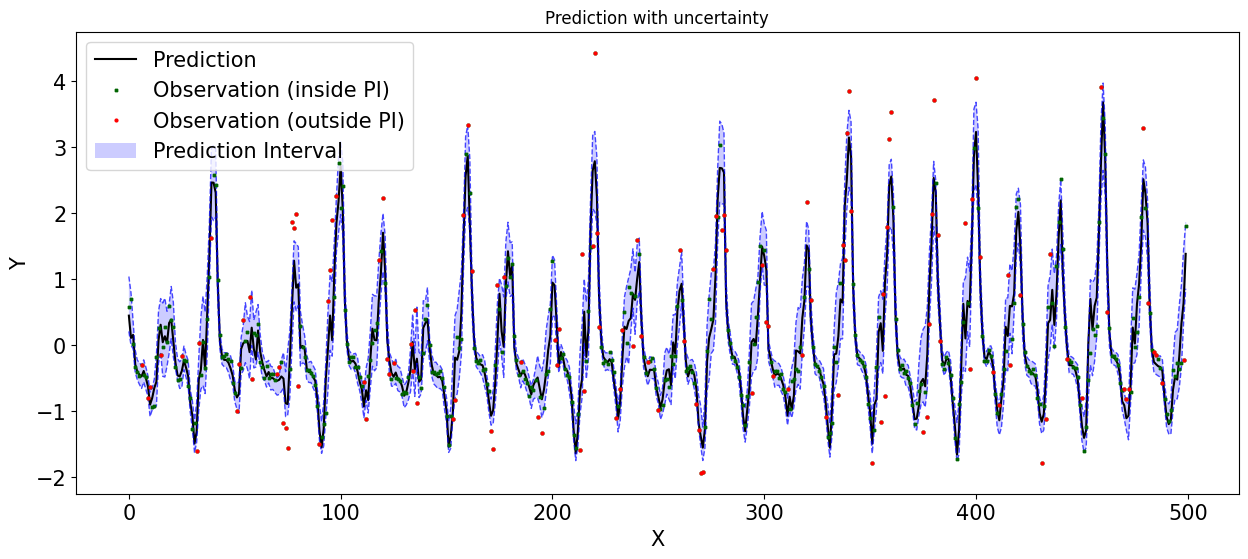

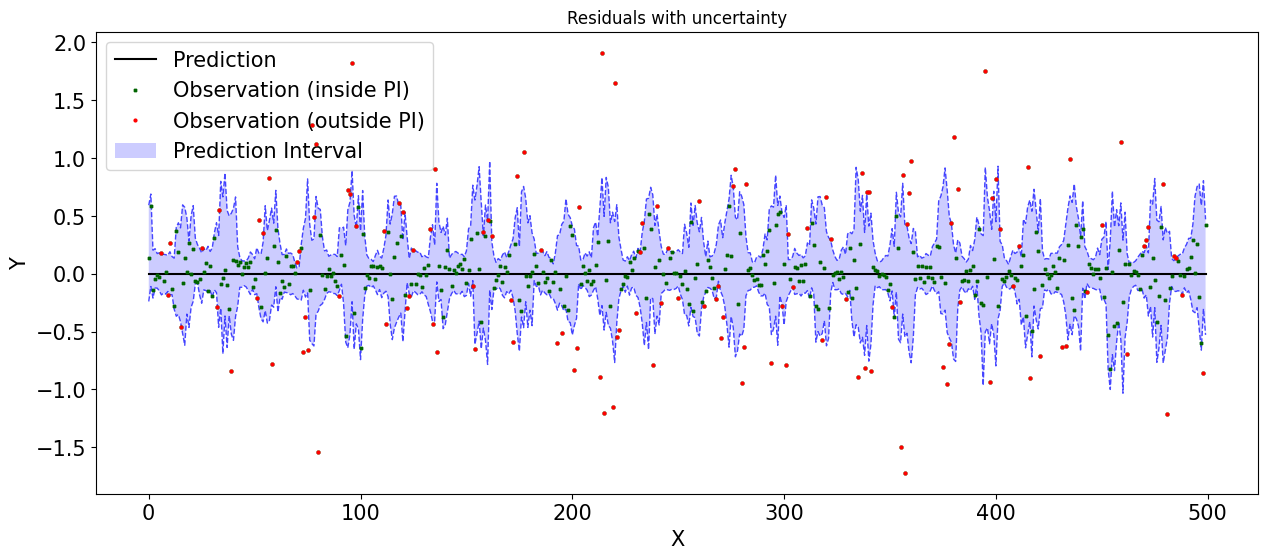

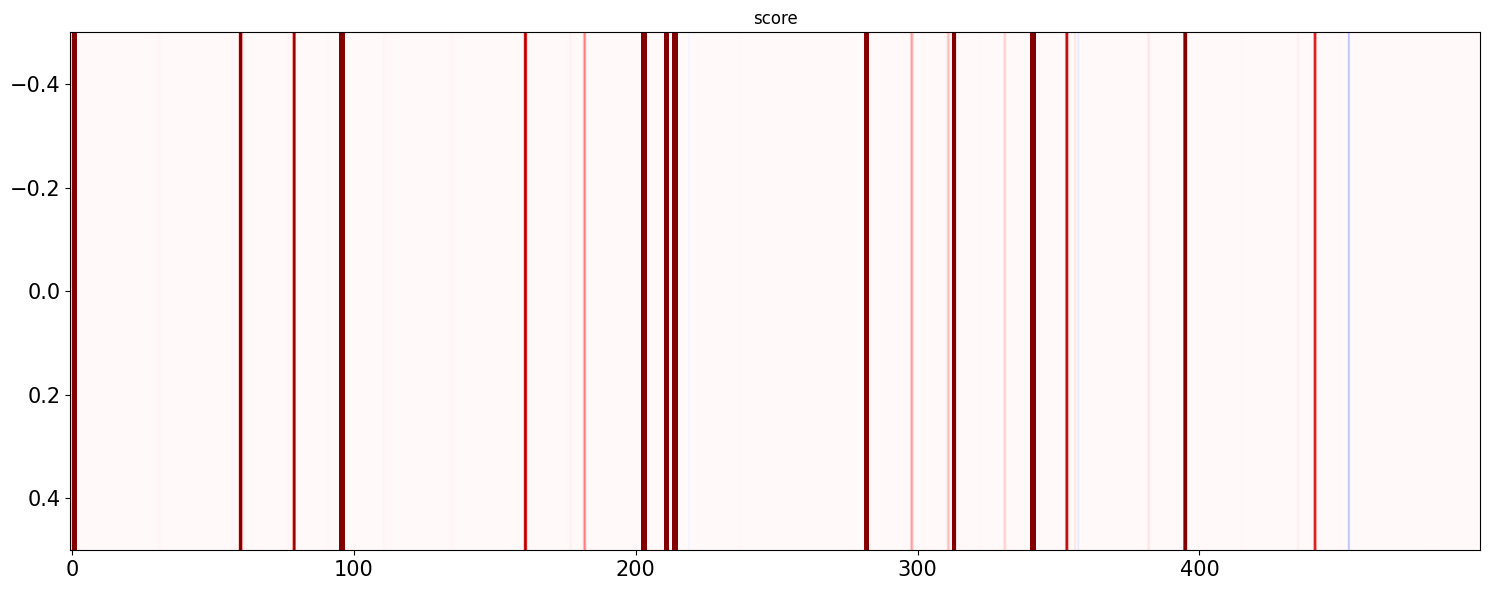

RF_UQEstimator var_A&E


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE TRAIN: 0.07 MSE TEST: 0.17
Coverage TRAIN: 1.0 Coverage TEST: 0.95
ACE TRAIN: 0.1 ACE TEST: 0.05
Sharpness TRAIN: 1.19 Sharpness TEST: 1.27


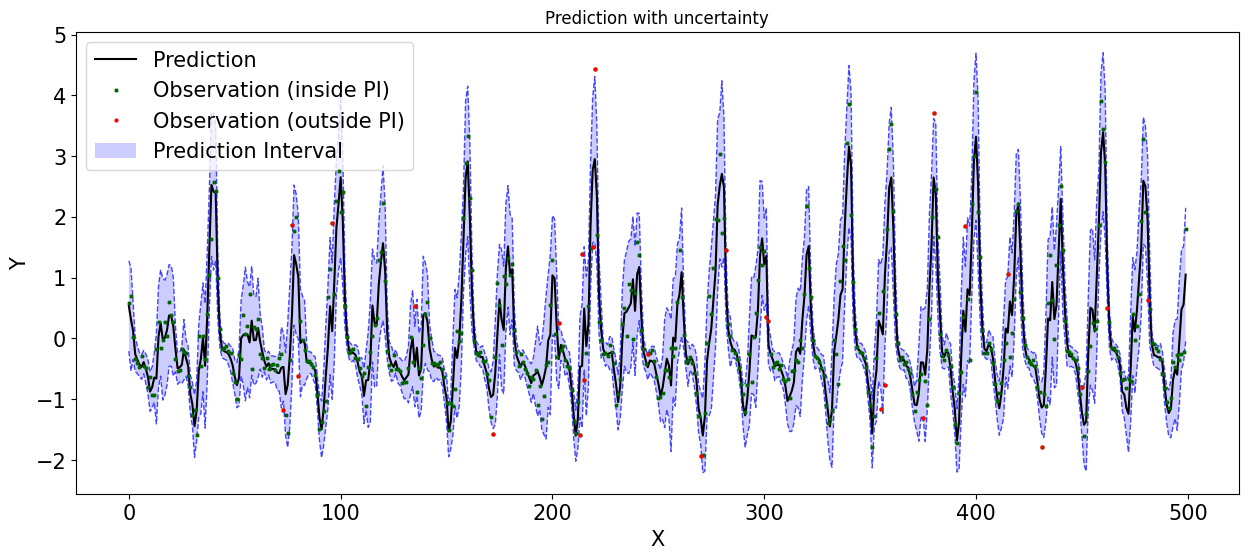

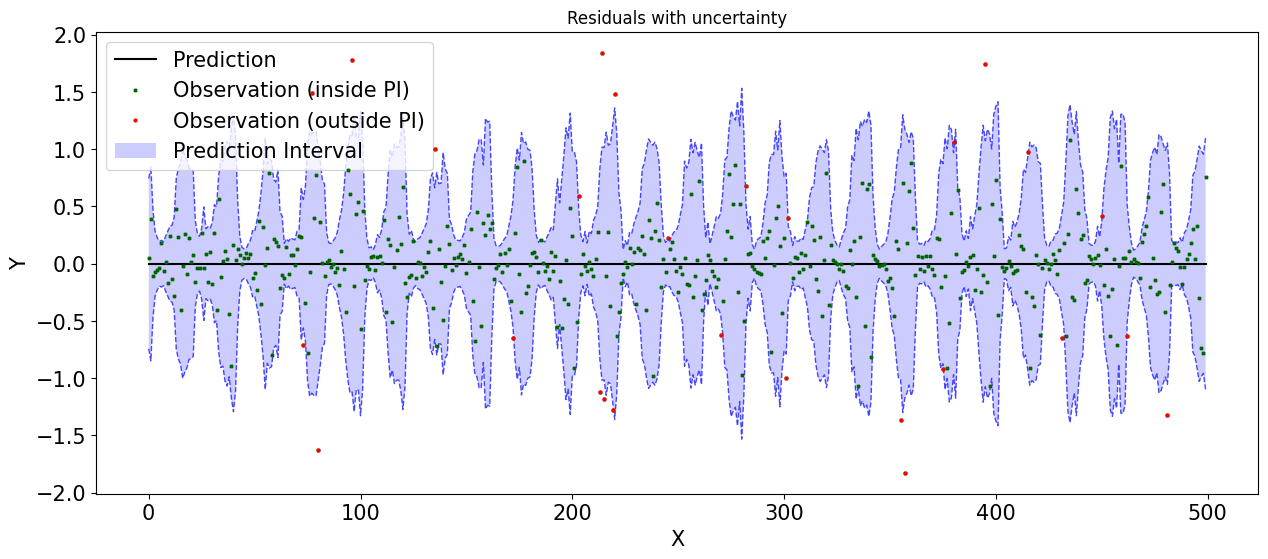

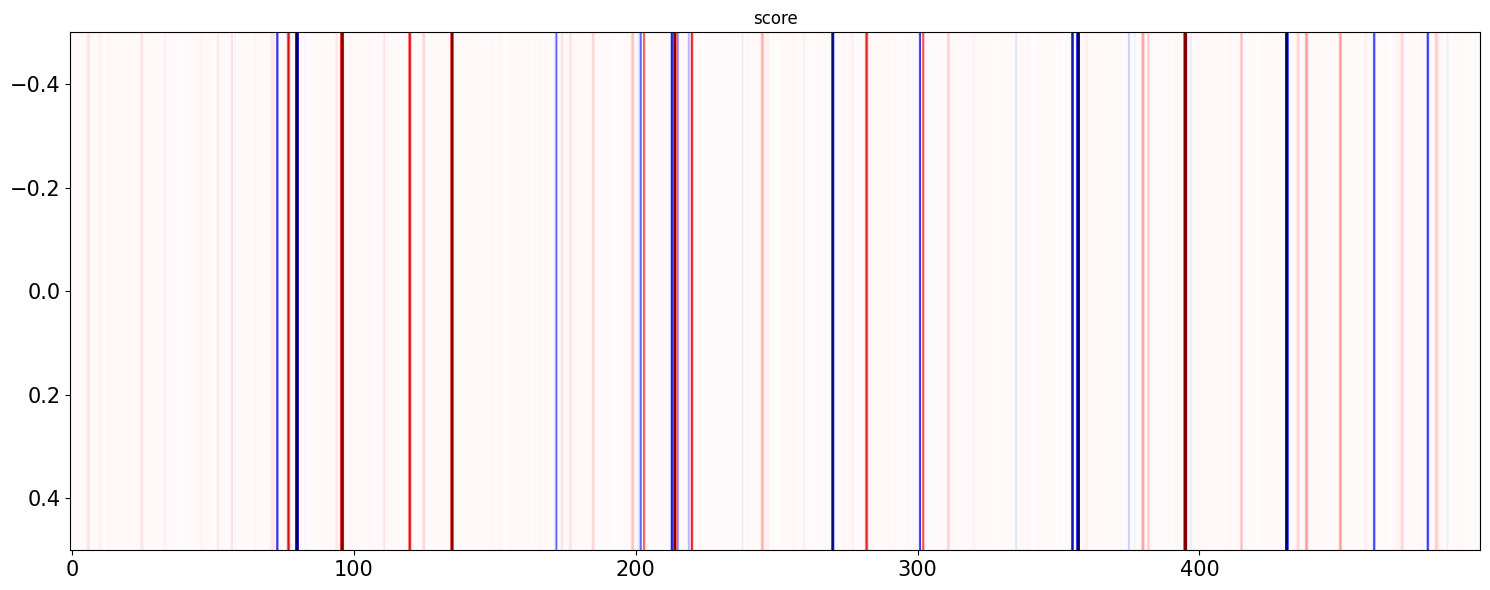

RF_UQEstimator res_var


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE TRAIN: 0.08 MSE TEST: 0.16
Coverage TRAIN: 0.97 Coverage TEST: 0.92
ACE TRAIN: 0.07 ACE TEST: 0.02
Sharpness TRAIN: 1.12 Sharpness TEST: 1.15


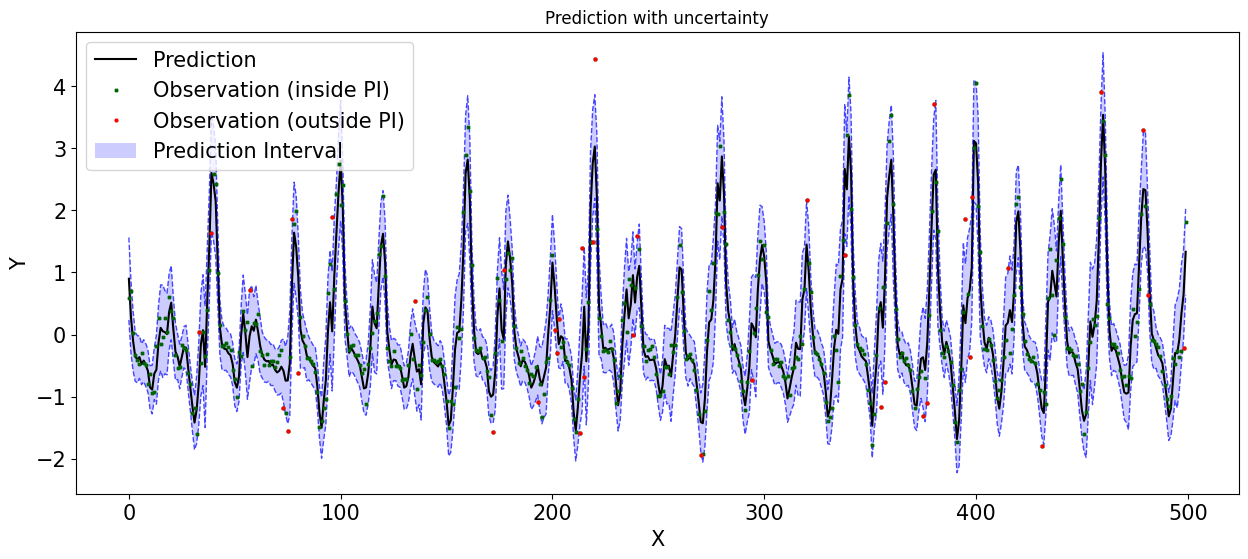

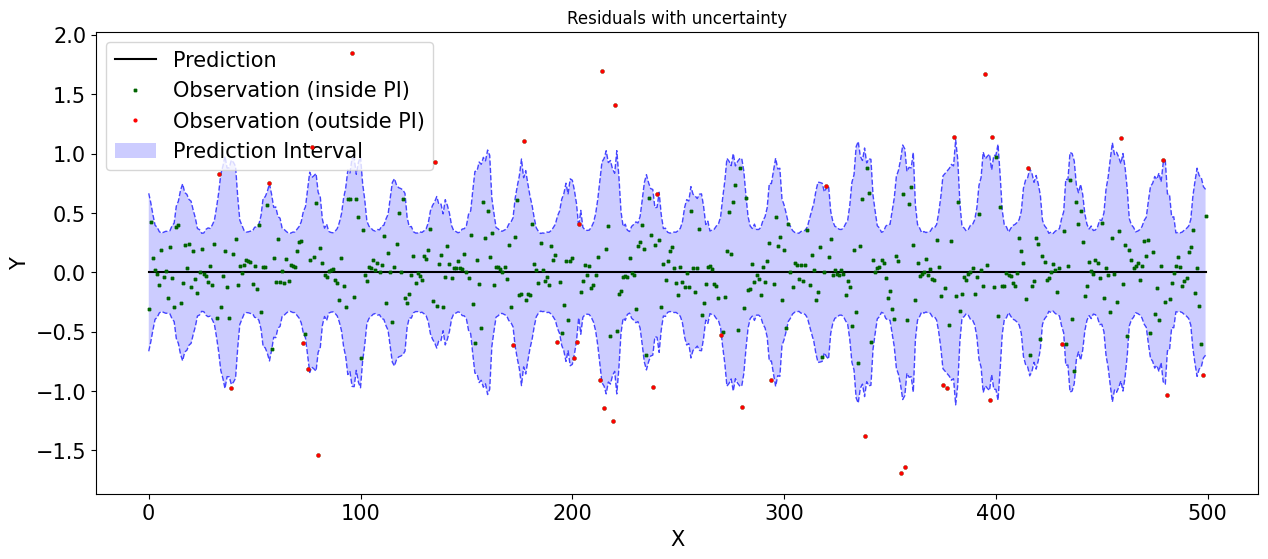

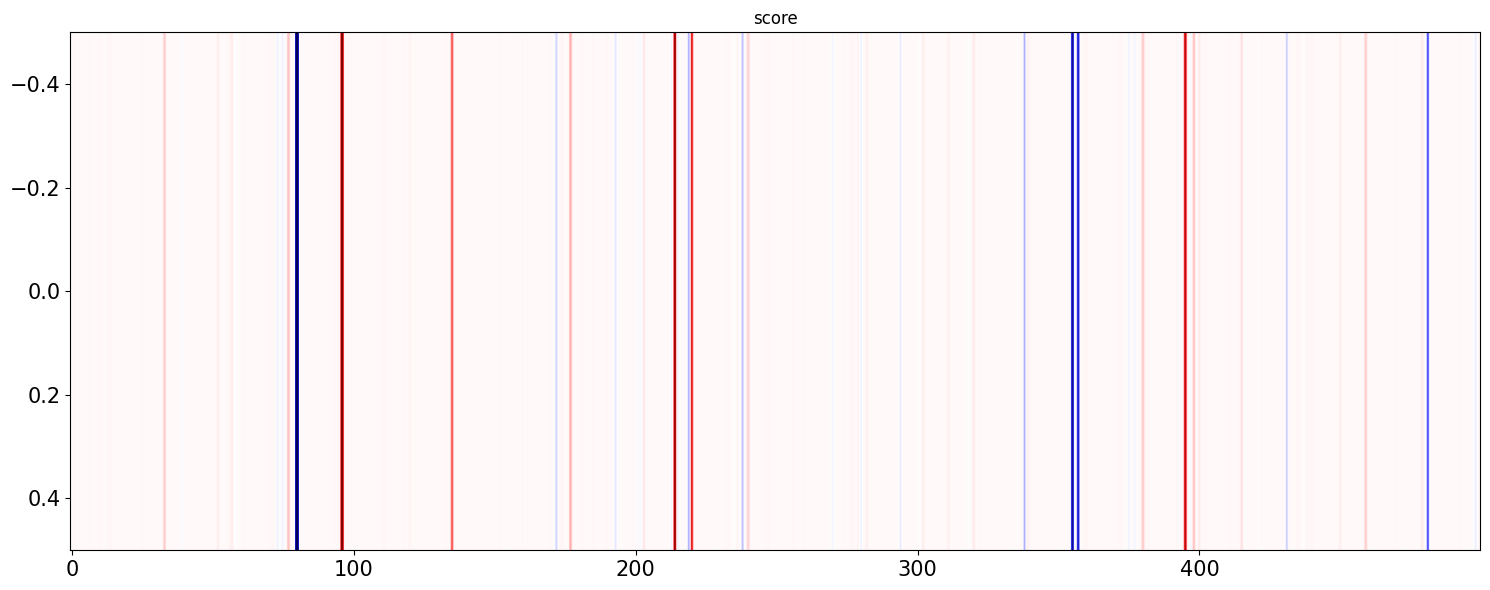

RF_UQEstimator res_2var


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Naïf approach mean of 2 sigma
Naïf approach mean of 2 sigma
MSE TRAIN: 0.08 MSE TEST: 0.17
Coverage TRAIN: 0.8 Coverage TEST: 0.73
ACE TRAIN: -0.1 ACE TEST: -0.17
Sharpness TRAIN: 0.64 Sharpness TEST: 0.64


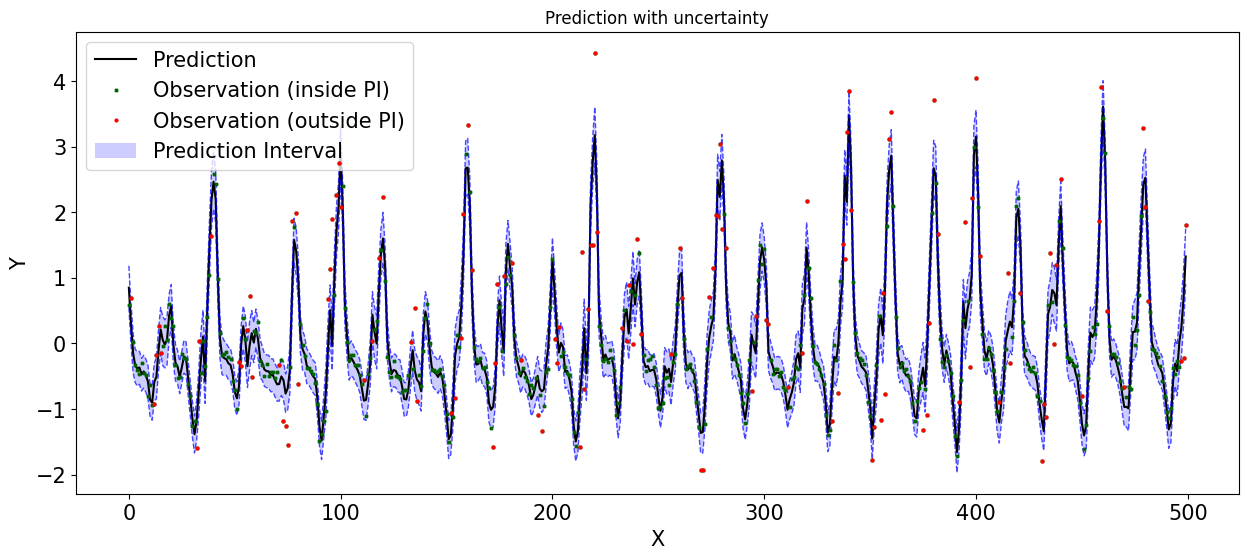

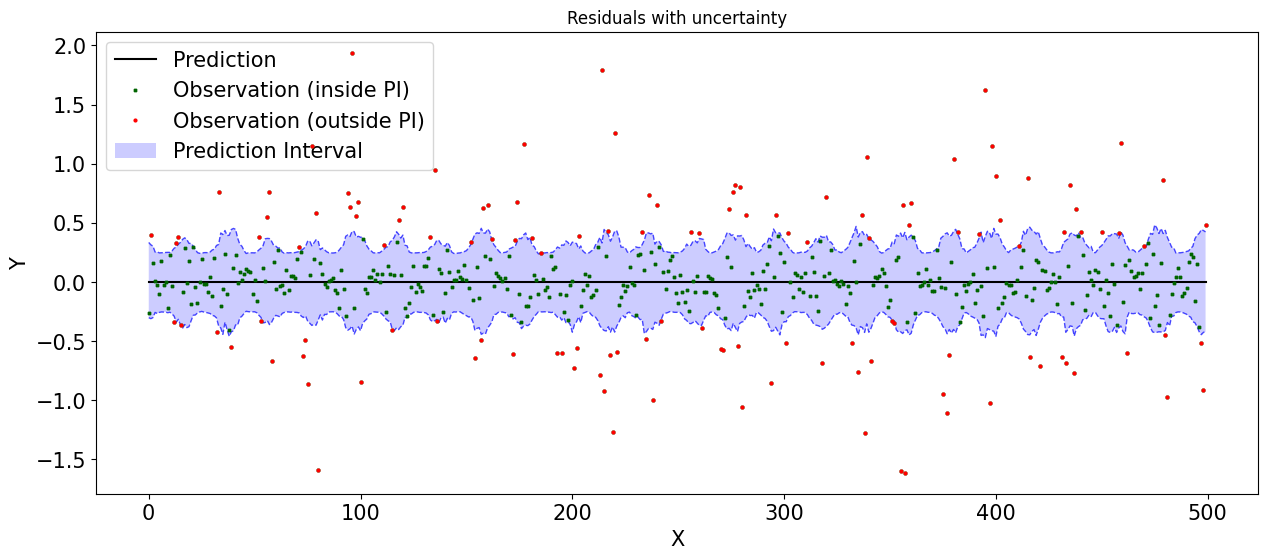

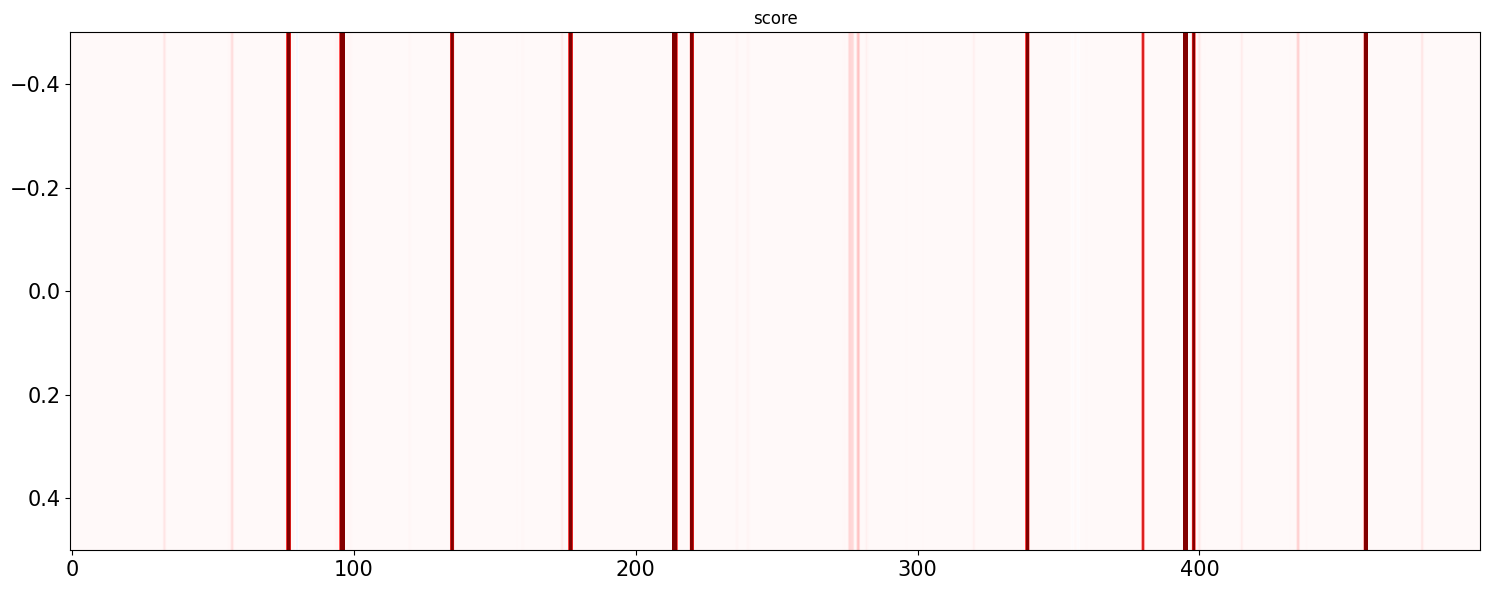

RF_UQEstimator res_quantile


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


recover quantile
recover quantile
MSE TRAIN: 0.08 MSE TEST: 0.17
Coverage TRAIN: 0.94 Coverage TEST: 0.83
ACE TRAIN: 0.04 ACE TEST: -0.07
Sharpness TRAIN: 0.86 Sharpness TEST: 0.86


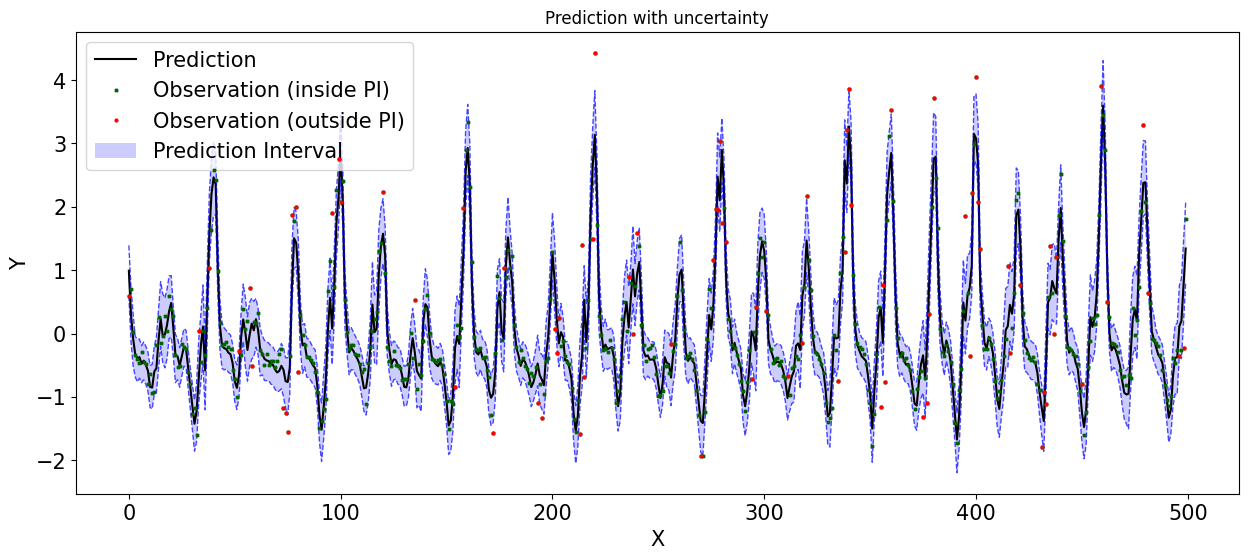

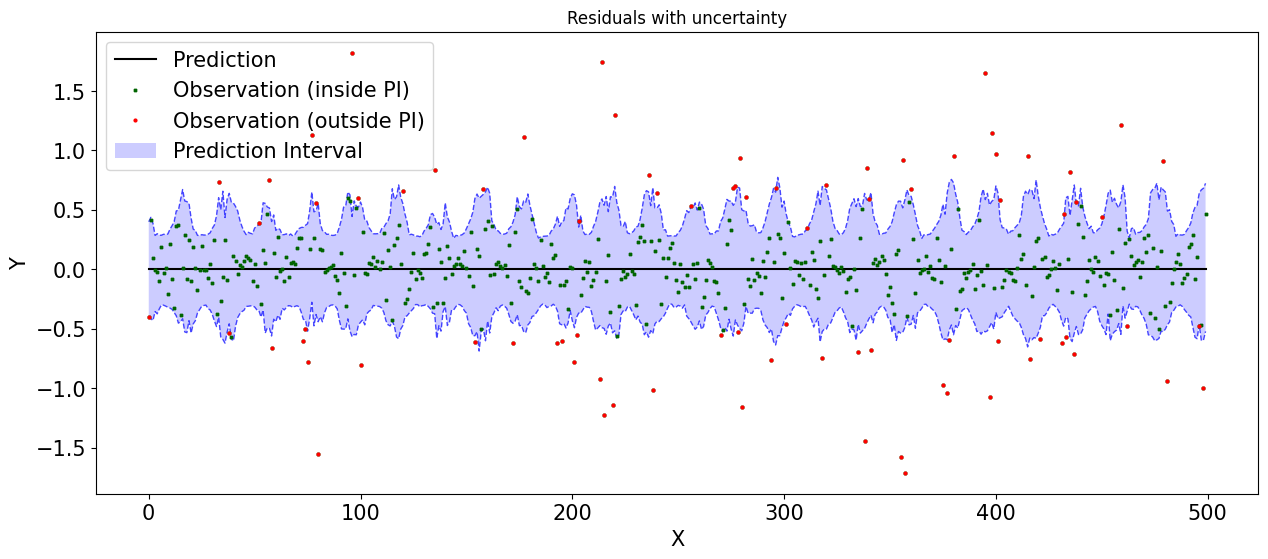

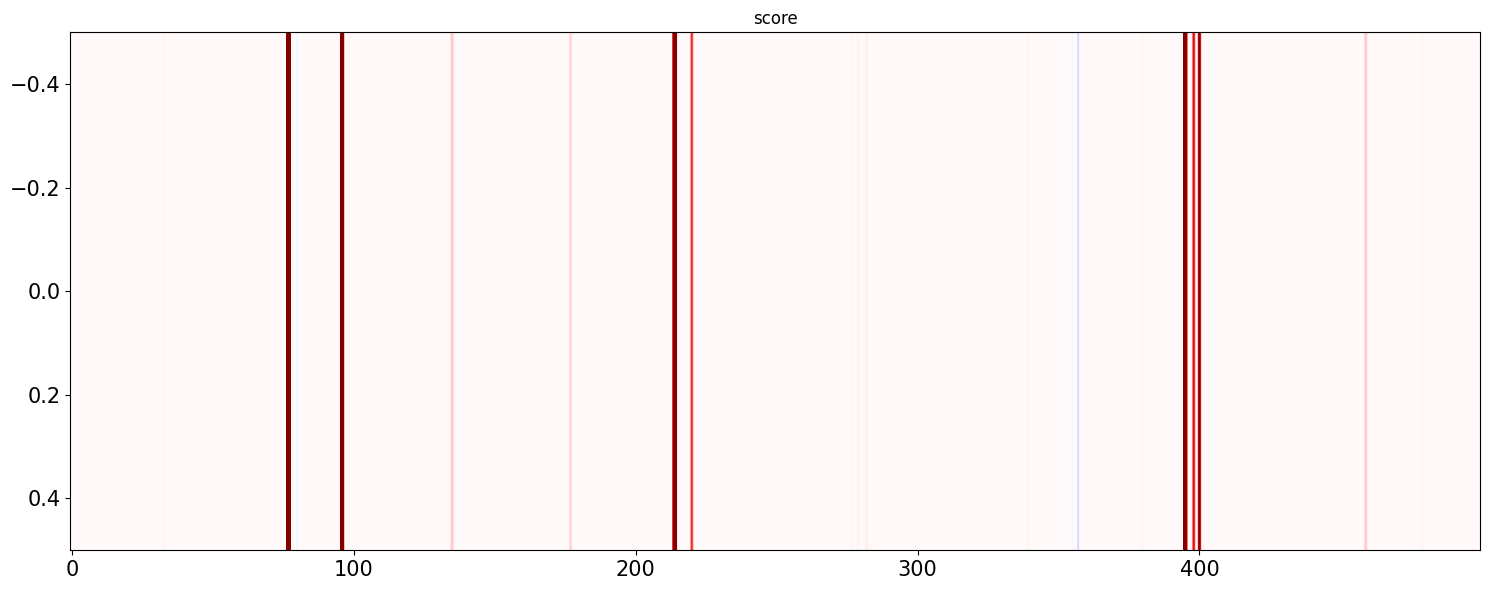

In [9]:
import uqmodels.postprocessing.UQKPI_Processor as UQProc

for intialiser,parameters in zip(list_UQEstimator_initialisers,list_UQEstimator_parameters):
    estimator = intialiser(**parameters)
    print(estimator.name,estimator.type_UQ)
    
    pred_model_train = 0
    pred_model = 0
    
    if(estimator.type_UQ is not False):
        if('res' in estimator.type_UQ):
            model_gbr.fit(X[train],y[train])
            pred_model = np.squeeze(model_gbr.predict(X))
            pred_model_train =  np.squeeze(pred_model[train])

    
    y_train = (np.squeeze(y[train])-pred_model_train).reshape(y[train].shape)
    estimator.fit(X[train], y_train)
    
    (pred,UQ) = estimator.predict(X)
    # Ensure good shape
    pred = (np.squeeze(pred) + pred_model).reshape(pred.shape)
    # Call to processing UQ:var or 2var to PIs
    
    PIs_processor = UQProc.NormalPIs_processor(KPI_parameters={"list_alpha": [0.05,0.95]})
    Anom_processor = UQProc.Anomscore_processor(KPI_parameters={"beta": 0.005,"d": 2})
    
    if(estimator.type_UQ in ['var','res_var']):
        UQ_train = UQ[train]
    elif(estimator.type_UQ in ['res_quantile','quantile','var_A&E','res_2var','2var']):
         UQ_train = UQ[:,train]
    
    # Execution of fit and transform procedure of PI_KPI_processor
    PIs_params_ = PIs_processor.fit(UQ=UQ_train,
                                    type_UQ=estimator.type_UQ,pred=pred[train],
                                    type_UQ_params=estimator.type_UQ_params,y=None)
    (y_pred_lower,y_pred_upper) = PIs_processor.transform(UQ=UQ,type_UQ=estimator.type_UQ,
                                                          pred=pred,type_UQ_params=estimator.type_UQ_params, 
                                                          y=None)
    
    # Execution of fit and predict of Anom_KPI_processor
    
    Anom_params_ = Anom_processor.fit(UQ=UQ_train,
                                      type_UQ=estimator.type_UQ,
                                      pred=pred[train],y=y[train],
                                      type_UQ_params=estimator.type_UQ_params)
    
    anom_score = Anom_processor.transform(UQ=UQ,
                                          type_UQ=estimator.type_UQ,
                                          pred=pred,y=y,
                                          type_UQ_params=estimator.type_UQ_params)
    
    print_metrics(y,pred,y_pred_lower,y_pred_upper,train,test)
    visu.plot_pi(
        y,
        pred,
        y_pred_lower,
        y_pred_upper,
        mode_res=False,
        f_obs = f_obs,
        name = 'Prediction with uncertainty',
        size = (15, 6))

    visu.plot_pi(
        y,
        pred,
        y_pred_lower,
        y_pred_upper,
        mode_res=True,
        f_obs = f_obs,
        name = 'Residuals with uncertainty',
        size = (15, 6))
    
    visu.plot_anom_matrice(score=anom_score,true_label=None,f_obs=f_obs,vmin=-4,vmax=4)
    del(estimator)
    del(anom_score)

# Test for KPI_parameters

In [10]:
# set of KPI parameters to test
dict_NormalPIs_processor_0 = {'list_alpha':[0.025,0.16,0.84,0.975],'with_epistemic':True}
dict_NormalPIs_processor_1 = {'list_alpha':[0.025,0.975],'with_epistemic':False}

Epistemicscorelvl_0 = {'mode':"score",'list_percent':[0.50, 0.80, 0.95, 0.98, 0.995, 1]}
Epistemicscorelvl_1 = {'mode':"levels",'list_percent':[0.10, 0.50, 0.90]}

dict_Anom1_processor_0 = {'beta':0.1,'mode':'score','fusion':False,'type_fusion':'mahalanobis','type_norm':'Nsigma_local','q_var':2}
dict_Anom2_processor_0 = {'beta':0.1,'mode':'born','fusion':True,'type_fusion':'mean','type_norm':'Nsigma_local','q_var':2}

dict_Anom1_processor_1 = {'beta':0.05,'mode':'score','fusion':False,'type_fusion':'mahalanobis','type_norm':'chebyshev_local','q_var':0.1}
dict_Anom2_processor_1 = {'beta':0.05,'mode':'born','fusion':True,'type_fusion':'mean','type_norm':'chebyshev_global','q_var':0.1}

dict_Anom1_processor_2 = {'beta':0.2,'mode':'score','fusion':False,'type_fusion':'mahalanobis','type_norm':'Cantelli_local','q_var':0.1}
dict_Anom2_processor_2 = {'beta':0.2,'mode':'born','fusion':True,'type_fusion':'mean','type_norm':'Cantelli_global','q_var':0.1}

dict_Anom1_processor_3 = {'beta':0.005,'mode':'score','fusion':False,'type_fusion':'mahalanobis','type_norm':'quantiles_local','q_var':0.1}
dict_Anom2_processor_3 = {'beta':0.005,'mode':'born','fusion':True,'type_fusion':'mean','type_norm':'quantiles_global','q_var':0.1,'q_Eratio':2}

dict_Anom1_processor_4 = {'beta':0.0005,'mode':'score','fusion':False,'type_fusion':'mahalanobis','type_norm':'Chi2','q_var':0.1,'q_var_e':0}
dict_Anom2_processor_4 = {'beta':0.0005,'mode':'born','fusion':True,'type_fusion':'mean','type_norm':'Chi2','q_var':0.1,'k_var_e':0}

list_KPI_parameters = [[dict_NormalPIs_processor_0,Epistemicscorelvl_0,dict_Anom1_processor_0,dict_Anom2_processor_0],
                       [dict_NormalPIs_processor_1,Epistemicscorelvl_1,dict_Anom1_processor_1,dict_Anom2_processor_1],
                       [dict_NormalPIs_processor_0,Epistemicscorelvl_1,dict_Anom1_processor_2,dict_Anom2_processor_2],
                       [dict_NormalPIs_processor_1,Epistemicscorelvl_0,dict_Anom1_processor_3,dict_Anom2_processor_3],
                       [dict_NormalPIs_processor_0,Epistemicscorelvl_0,dict_Anom1_processor_4,dict_Anom2_processor_4]]

# We can also create a more complexe UQmodel that handle several UQKPI_Processor to build at inference (UQMesure, Predictive interval and model unreliability score) and after observation (Anomaly score)
# Specification of the UQestimator
from uqmodels.UQModel import UQModel
import uqmodels.postprocessing.UQKPI_Processor as UQProc

for n,(KPI_params_Normal,KPI_params_Epistemic,KPI_params_Anom1,KPI_params_Anom2) in enumerate(list_KPI_parameters):
    UQEstimator_initializer = RF_UQEstimator
    RF =  RandomForestRegressor(min_samples_leaf=5,n_estimators=50,max_depth=10,ccp_alpha=0.0005,max_samples=0.7)
    UQEstimator_parameters = {'estimator':RF,'var_min':0.002,'type_UQ':'var_A&E','rescale':True,'random_state':0}

    # Instanciation of PostProcesseur that provide UQ measure.
    UQ_proc = UQProc.UQKPI_Processor(KPI_parameters={'pred_and_UQ':n==0})

    # PostProcesseur that compute Predictive intervals
    PIs_proc = UQProc.NormalPIs_processor(KPI_parameters=KPI_params_Normal)
    # PostProcesseur  that compute an epistemics lvl score
    Elvl_proc = UQProc.Epistemicscorelvl_processor(KPI_parameters=KPI_params_Epistemic)
    # PostProcesseur Instanciation that compute an epistemics lvl score
    Anom_proc1 = UQProc.Anomscore_processor(KPI_parameters=KPI_params_Anom1)
    Anom_proc2 = UQProc.Anomscore_processor(KPI_parameters=KPI_params_Anom2)
    # Instanciation of the UQmodel modeling pipeline
    RF_UQModel = UQModel(UQEstimator_initializer,
                         UQEstimator_parameters,
                         name='UQModels',
                         predictor=None,
                         list_predict_KPI_processors=[UQ_proc,PIs_proc,Elvl_proc],
                         list_score_KPI_processors=[Anom_proc1,Anom_proc2],
                         cache_manager=None)

    # Fit procedure
    RF_UQModel.fit(X[train],y[train])
    # Inference procedure that provide prediction plus the specified UQKPIs
    pred,(UQ,PIs,Elvl) = RF_UQModel.predict(X)
    # Score procedure that provide ANom-KPI
    KPI_anom1,KPI_anom2 = RF_UQModel.score(X,y)
    print('Done run ',n)

C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Done run  0


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Done run  1


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Done run  2


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Done run  3


C:\FONDATION\Support_composants\env-uqmodels\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Done run  4
